# Setup

## Imports

In [3]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import matplotlib.patches as patches
import matplotlib
from matplotlib import cm

import cartopy.crs as ccrs
import cmocean
import seaborn as sns
#import holoviews as hv

import threading
import dask
from dask.diagnostics import ProgressBar
dask.config.set({'temporary_directory': '/home/s1205782/tmp'})

from climatetranslation.unit.utils import get_config
from climatetranslation.unit.data import (
    get_dataset, 
    construct_regridders,
    get_land_mask as _get_land_mask,
    precip_kilograms_to_mm,
    precip_mm_to_kg,
    dataset_time_overlap
)

import time
from tqdm import tqdm

projection = ccrs.PlateCarree()
xr.set_options(keep_attrs=True)
#hv.extension('matplotlib') # hv.extension('bokeh')

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.preprocessing import quantile_transform as _quantile_transform

def quantile_transform(x):
    if isinstance(x, tuple):
        return tuple(quantile_transform(xn) for xn in x)
    if isinstance(x, xr.DataArray):
        da = xr.zeros_like(x)
        da.values[:] = quantile_transform(x.values)
        return da
    if len(x.shape)==1: 
        return _quantile_transform(x[:, None])[:, 0]
    else:
        return _quantile_transform(x)

In [5]:
conf = get_config("/home/s1205782/geos-fulton/model_outputs/outputs/v8.2_monsoon_hadgem_to_era5/config.yaml")

In [6]:
conf

{'image_save_iter': 10000,
 'image_display_iter': 100,
 'display_size': 16,
 'snapshot_save_iter': 2000,
 'log_iter': 10,
 'max_iter': 1000000,
 'batch_size': 8,
 'weight_decay': 0.0001,
 'beta1': 0.5,
 'beta2': 0.999,
 'init': 'kaiming',
 'lr': 0.0005,
 'lr_policy': 'step',
 'step_size': 100000,
 'gamma': 0.5,
 'gan_w': 1,
 'recon_x_w': 10,
 'recon_x_multi': [5, 1, 1, 1, 1],
 'recon_h_w': 0,
 'recon_kl_w': 0.005,
 'recon_x_cyc_w': 10,
 'recon_kl_cyc_w': 0.005,
 'recon_loss_func': 'mae',
 'gen': {'dim': 128,
  'norm': 'bn',
  'activ': 'lrelu',
  'n_downsample': 2,
  'n_res': 1,
  'pad_type': 'replicate',
  'upsample': 'nearest',
  'output_activ': ['relu', 'none', '-relu', 'relu', 'none']},
 'dis': {'dim': 128,
  'norm': 'bn',
  'activ': 'lrelu',
  'n_layer': 4,
  'gan_type': 'lsgan',
  'num_scales': 3,
  'pad_type': 'replicate'},
 'num_workers': 5,
 'data_zarr_a': '/home/s1205782/geos-fulton/datadrive/era5/all_hist_global_zarr',
 'data_zarr_b': '/home/s1205782/geos-fulton/datadrive/had

## Functions

In [7]:
def select_months(da, months, drop=False):
    in_months = xr.DataArray(np.isin(da['time.month'], months), coords=[da.time])
    return da.where(in_months, drop=drop)

def common_min_max_arrays(arrays):
    vmin = min([x.min() for x in arrays])
    vmax = max([x.max() for x in arrays])
    return vmin, vmax

def common_min_max(das):
    vmin = min([da.min() for da in das]).values
    vmax = max([da.max() for da in das]).values
    return vmin, vmax

def calc_range(das):
    vmin, vmax = common_min_max(das)
    return (vmax - vmin)

def clip(da, vmin, vmax):
    """A clip functrion which keeps attributes"""
    attrs = da.attrs
    x = da.clip(vmin, vmax)
    x.attrs = attrs
    return x

def lat_lon_range(lat_or_lon):
    d = np.diff(lat_or_lon)[0]
    return (lat_or_lon.min() - d/2, lat_or_lon.max() + d/2)

def get_land_mask(ds):
    return _get_land_mask(ds).cpu().numpy()

def kel2cel(ds):
    for k in ds.keys():
        ds[k] = ds[k] - 273.15
    return ds

def trim_plot(ds, ax):
    lat = ds.lat.values
    lon = ds.lon.values
    dlat = (lat[1]-lat[0])*.5
    dlon = (lon[1]-lon[0])*.5
    ax.set_ylim(lat[0]-dlat, lat[-1]+dlat)
    ax.set_xlim(lon[0]-dlon, lon[-1]+dlon)

In [8]:
locs = {
    'Southern tip of India': dict(lon=77.5, lat=8.5), 
    'other':dict(lon=58.25, lat=28),
    'other2':dict(lon=75, lat=18),
    'Sumatra':dict(lon=100.8, lat=0.3),
    'Arabian Sea':dict(lon=63.4, lat=8.8),
}

def pr_axis(ax, labels=None, both=False, ylabels=None):
    if labels is None:
        ticks = ax.get_xticks()
        labels = np.array(ticks)**4
    ticks = np.array(labels)**.25
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    if both:
        if ylabels is None:
            ticks = ax.get_xticks()
            ylabels = np.array(ticks)**4
        ticks = np.array(ylabels)**.25
        ax.set_yticks(ticks)
        ax.set_yticklabels(ylabels)
        

def select_named_loc(ds, loc_string):
    return ds.sel(**locs[loc_string], method='nearest')

def pr_transform(ds, loc_string=None):
    ds = ds.isel(run=0)
    if loc_string is not None:
        ds = select_named_loc(ds, loc_string)
    x = ds.pr.clip(None, 75)**.25
    return x

def tas_transform(ds, loc_string=None):
    if loc_string is not None:
        ds = select_named_loc(ds, loc_string)
    x = ds.isel(run=0).tas#.clip(1e-2, None)
    return x

## Load data

In [9]:
conf_levels = conf['level_vars']
bbox = conf['bbox']

In [10]:
ds_target = get_dataset(f"/home/s1205782/geos-fulton/datadrive/era5/all_hist_global_zarr", 
                      conf_levels, 
                      filter_bounds=False,
                      split_at=360, 
                      bbox=bbox)

hadgem_root = "/home/s1205782/geos-fulton/datadrive/hadgem3/test_set"

ds_base = get_dataset(f"{hadgem_root}/all_hist_zarr", 
                      conf_levels, 
                      filter_bounds=False,
                      split_at=360, 
                      bbox=bbox)

ds_trans = get_dataset(f"{hadgem_root}/v8.2_monsoon_to_era5_40k",
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)

ds_transqm = get_dataset(f"{hadgem_root}/v8.2_monsoon_unit40k_and_qm_to_era5",
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)

ds_qm = get_dataset(#f"/datadrive/hadgem3/all_hist_quantile_monsoon_zarr",
                    f"{hadgem_root}/all_hist_qm_to_era_monsoon_zarr",
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)


rg_t, rg_b = construct_regridders(
    ds_target, 
    ds_base, 
    resolution_match='downscale', 
    scale_method='conservative', 
    periodic=False)

if rg_t is not None:
    ds_target = rg_t(ds_target)
if rg_b is not None:
    ds_base = rg_b(ds_base)
    
if conf['time_range'] is not None:
    if conf['time_range'] == 'overlap':
        ds_target, ds_base, ds_trans, ds_transqm, ds_qm = (
            dataset_time_overlap([ds_target, ds_base, ds_trans, ds_transqm, ds_qm])
        )
    elif isinstance(conf['time_range'], dict):
        time_slice = slice(conf['time_range']['start_date'], conf['time_range']['end_date'])
        ds_target, ds_base, ds_trans, ds_transqm, ds_qm = [
            ds.sel(time=time_slice) for ds in [ds_target, ds_base, ds_trans, ds_transqm, ds_qm]
        ]
    else:
        raise ValueError("time_range not valid : {}".format(conf['time_range']))

{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)


In [11]:
def add_title(ds, title):
    ds.attrs['title'] = title
    for k in ds.keys():
        ds[k].attrs['title'] = title
        
add_title(ds_target, "ERA5")
add_title(ds_base, "HadGEM3")
add_title(ds_trans, "UNIT")
add_title(ds_transqm, "UNIT+QM")
add_title(ds_qm, "QM")

In [12]:
all_ds = [ds_target, ds_base, ds_trans, ds_transqm, ds_qm]

In [13]:
for ds in all_ds:
    precip_kilograms_to_mm(ds)

In [15]:
with ProgressBar(dt=10):
    all_ds = dask.compute(all_ds)[0]

[########################################] | 100% Completed | 13min 24.8s


In [45]:
def _quant_plot(x, ax, d=0.01):
    x = quantile_transform(x)
    ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
    #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
    ax.annotate(x[1].attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
    sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )
    ylim = (0-d,1+d) # ax.get_ylim()
    xlim = (0-d,1+d) # ax.get_xlim()
    
    #rect1 = matplotlib.patches.Rectangle((-1,-1), 1, 3, color='white',zorder=2)
    #ax.add_patch(rect1)

    #rect1 = matplotlib.patches.Rectangle((-1,-1), 3, 1, color='white',zorder=2)
    #ax.add_patch(rect1)
    
    #rect1 = matplotlib.patches.Rectangle((1,-1), 1, 3, color='white',zorder=2)
    #ax.add_patch(rect1)

    #rect1 = matplotlib.patches.Rectangle((-1,1), 3, 1, color='white',zorder=2)
    #ax.add_patch(rect1)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

def plot_vrac(xs, xlabel, ylabel, d=0.01):
    fig = plt.figure()
    s=1.3
    fig, axes = plt.subplots(3,2, figsize=(6*s,8*s), sharex=True, sharey=True)

    for x, ax in zip(xs, axes.flatten()[[0,2,3,4,5]]):
        _quant_plot(x, ax, d=d)

    for ax in axes[-1,:]:
        ax.set_xlabel(xlabel)
    for ax in axes[:,0]:
        ax.set_ylabel(ylabel)
    
    axes[0, -1].axis('off')

    return fig

# Simple plots

## Old field animation

In [18]:
def transform(ds):
    x = clip(ds.pr.isel(time=slice(0,2000), run=0), 0, None)**.25
    x['time'] = np.arange(x.time.shape[0])
    return x


def get_images(ds_list, **kwargs):
    hv_list = []
    for ds in ds_list:
        hv_ds = hv.Dataset(transform(ds))
        hv_list.append(
            hv_ds.to(hv.Image, ['lon', 'lat'])
            .options(**kwargs, title=ds.attrs['title'])
        )
    return hv_list
        

# colorbars are matched if the variables have the same names
#images_list = get_images(all_ds, 
#    #height=180,
#    #width=360,
#    cmap=cmocean.cm.rain,
#    colorbar=True,
#    projection=projection,
#    #coastline=True,
#)

#images = images_list[0]
#for im in images_list[1:]:
#    images = images+im

In [16]:
#hv.save(images, 'precips.gif', fps=3)

In [17]:
#%%output holomap='scrubber'
#images

## Plot means

In [18]:
def plot_mean_var(var):
    ds_means = [ds[var].mean(dim='time').isel(run=0) for ds in all_ds]
    vmin, vmax = common_min_max([ds for ds in ds_means])
    fig, axes = plt.subplots(2,3, figsize=(16,6))
    axes = axes.flatten()
    for ds, ax in zip(ds_means, axes):
        ds.plot(ax=ax, vmin=vmin, vmax=vmax)
        ax.set_title(ds.attrs['title'])
    plt.tight_layout()
    plt.show()

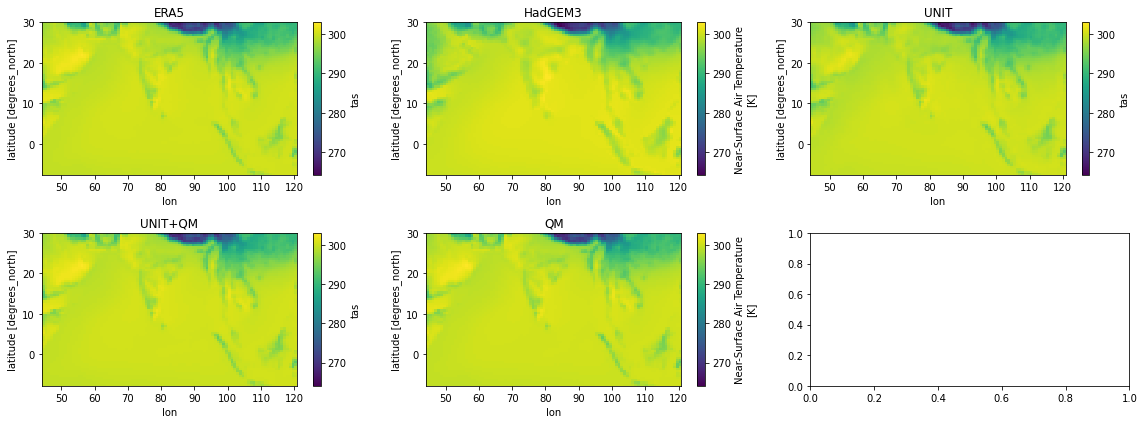

In [19]:
plot_mean_var('tas')

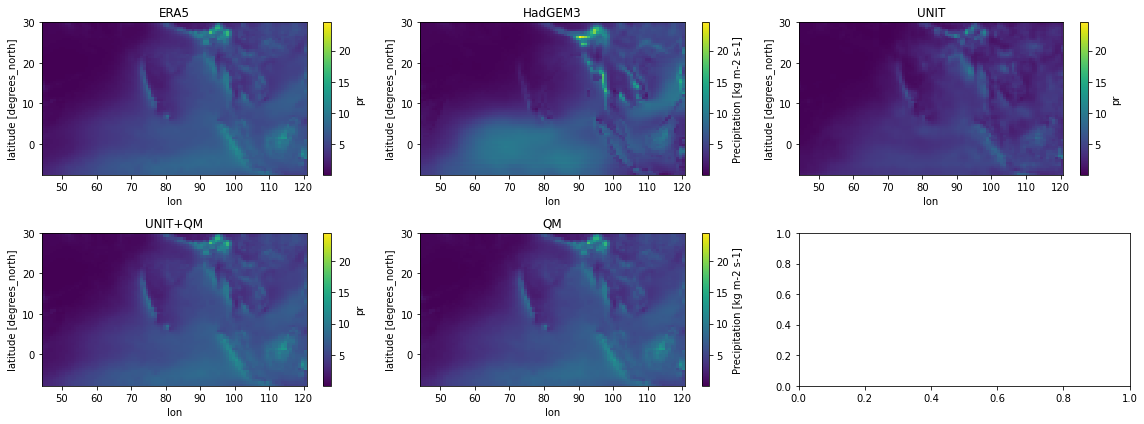

In [20]:
plot_mean_var('pr')

## 1D precip dist

In [19]:
tip_india = 'Southern tip of India'

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

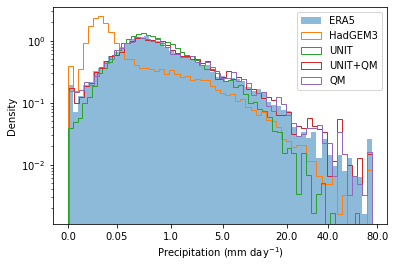

In [149]:
fig, ax = plt.subplots(1,1)

for ds in all_ds:
    histtype='stepfilled' if ds.attrs['title']=='ERA5' else 'step'
    alpha = 0.5 if ds.attrs['title']=='ERA5' else 1
    pr_transform(ds, tip_india).plot.hist(
        bins=60, label=ds.attrs['title'], 
        density=True, alpha=alpha, 
        histtype=histtype, ax=ax, 
        log=True
    )
    pr_axis(ax, np.array([0, 0.05, 1, 5, 20, 40, 80]))
plt.legend()#loc='upper left')
plt.title(None)
plt.xlabel('Precipitation (mm day$^{-1}$)')
plt.ylabel('Density')
#plt.ylim(0, 50)
plt.show()

## 1D translation mapping

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

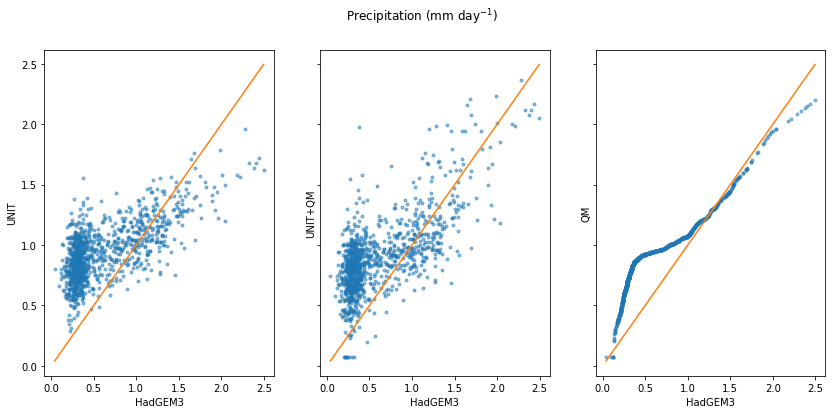

In [24]:
xs = [pr_transform(ds, tip_india) for ds in all_ds[1:]]

fig, axes = plt.subplots(1,len(xs)-1,sharex=True, sharey=True, figsize=(14,6))
for d, ax in zip(xs[1:], axes):
    mask = d.time.dt.month==6
    y = d.where(mask, drop=True)
    x = xs[0].where(mask, drop=True)
    ax.plot(x, y, label=d.attrs['title'], marker='.', linestyle='', alpha=.5)
    
    vmin, vmax = common_min_max([x, y])
    ax.plot([vmin, vmax], [vmin, vmax])
    
    #pr_axis(ax, np.array([0, 0.05, 1, 5, 20, 40, 80]),both=True)
    #ax.legend(title='BC method')#loc='upper left')
    ax.set_xlabel('HadGEM3')
    ax.set_ylabel(d.attrs['title'])
plt.suptitle("Precipitation (mm day$^{-1}$)")
plt.show()

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

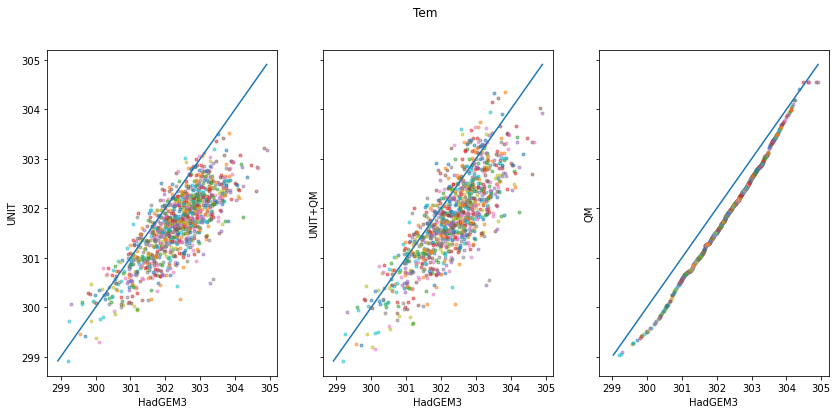

In [25]:
xs = [select_named_loc(ds, tip_india).tas for ds in all_ds[1:]]

fig, axes = plt.subplots(1,len(xs)-1,sharex=True, sharey=True, figsize=(14,6))
for d, ax in zip(xs[1:], axes):
    mask = d.time.dt.month==6
    y = d.where(mask, drop=True)
    x = xs[0].where(mask, drop=True)
    ax.plot(x, y, label=d.attrs['title'], marker='.', linestyle='', alpha=.5)
    
    vmin, vmax = common_min_max([x, y])
    ax.plot([vmin, vmax], [vmin, vmax])
    
    #pr_axis(ax, np.array([0, 0.05, 1, 5, 20, 40, 80]),both=True)
    #ax.legend(title='BC method')#loc='upper left')
    ax.set_xlabel('HadGEM3')
    ax.set_ylabel(d.attrs['title'])
plt.suptitle("Tem")
plt.show()

## Neighbouring precip joint plot

In [46]:
def _transform(ds, loc_string, loc_string2=None):
    x = pr_transform(ds, loc_string)
    if loc_string2 is None:
        ilat = np.where(ds.lat.values == x.lat.item())[0].item()
        ilon = np.where(ds.lon.values == x.lon.item())[0].item()
        y = ds.isel(run=0, lat=ilat, lon=ilon+1).pr.clip(None, 75)**.25
    else:
        y = ds.isel(run=0).sel(**locs[loc_string2], method='nearest').pr.clip(None, 75)**.25
    return x, y 

xs = [_transform(ds, tip_india) for ds in all_ds]

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

<Figure size 432x288 with 0 Axes>

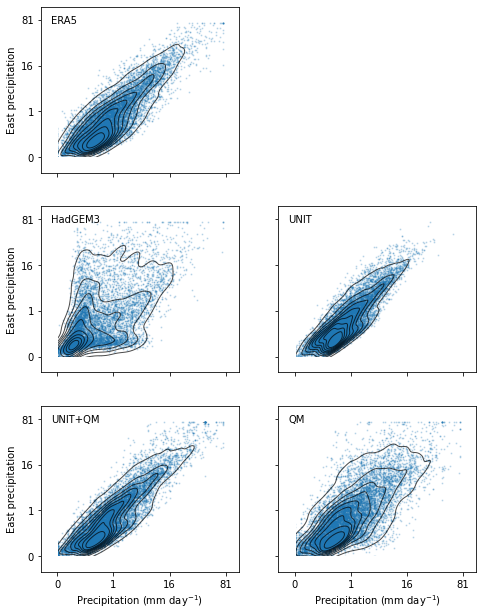

In [37]:
plt.figure()
s=1.3
fig, axes = plt.subplots(3,2, figsize=(6*s,8*s), sharex=True, sharey=True)

def _plot(x, ax):
    ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
    #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
    ax.annotate(x[1].attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
    sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    rect1 = matplotlib.patches.Rectangle((-1,-10), 1, 100, color='white', zorder=2)
    rect2 = matplotlib.patches.Rectangle((-10,-1), 100, 1, color='white', zorder=2)
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

for x, ax in zip(xs, axes.flatten()[[0,2,3,4,5]]):
    _plot(x, ax)
    pr_axis(ax, np.array([0, 1, 16, 81]), both=True, ylabels=np.array([0, 1, 16, 81]))
    
for ax in axes[-1,:]:
    ax.set_xlabel(r'Precipitation (mm day$^{-1}$)')
for ax in axes[:,0]:
    ax.set_ylabel(r'East precipitation')
    
axes[0, -1].axis('off')

#plt.savefig("figs/neighbouring_gridpoints_pr_joint.png", dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

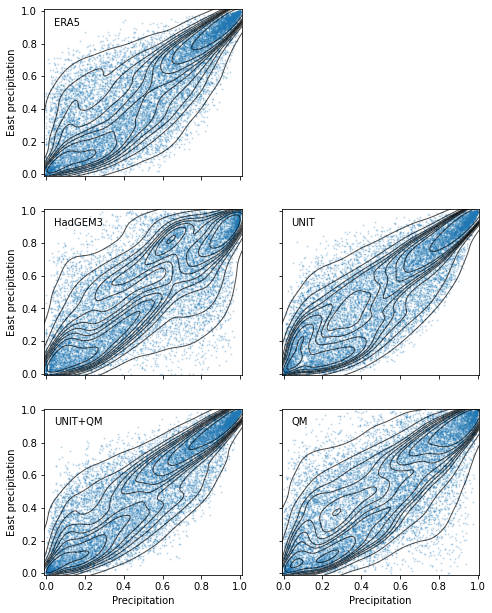

In [49]:
plot_vrac(xs, xlabel=r'Precipitation', ylabel=r'East precipitation', d=0.01)
plt.savefig("figs/neighbouring_gridpoints_pr_joint_vrac.png", dpi=300)
plt.show()

## 2D single loc joint plot precip-temp

In [54]:
def _transform(ds, loc_string):
    ds = ds.isel(run=0).sel(**locs[loc_string], method='nearest')
    x = ds.pr.clip(None, 75)**.25
    y = ds.tas-273#.isel(time=slice(None, None, 10)
    return x, y

In [52]:
xs = [_transform(ds, tip_india) for ds in all_ds]

plt.figure()
s=1.3
fig, axes = plt.subplots(3,2, figsize=(6*s,8*s), sharex=True, sharey=True)

def _plot(x, ax):
    ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
    #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
    ax.annotate(x[1].attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
    sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    rect1 = matplotlib.patches.Rectangle((-1,0), 1, 100, color='white',zorder=2)
    ax.add_patch(rect1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

for x, ax in zip(xs, axes.flatten()[[0,2,3,4,5]]):
    _plot(x, ax)
    pr_axis(ax, np.array([0, 1, 16, 81]))
    
for ax in axes[-1,:]:
    ax.set_xlabel(r'Precipitation (mm day$^{-1}$)')
for ax in axes[:,0]:
    ax.set_ylabel(r'Temperature (°C)')
    


axes[0, -1].axis('off')

#plt.suptitle(f"Joint distribution of variables at single grid point - {this_loc}")

plt.savefig("figs/single_location_joint_tip_india.png", dpi=300)
plt.close()

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

<Figure size 432x288 with 0 Axes>

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

<Figure size 432x288 with 0 Axes>

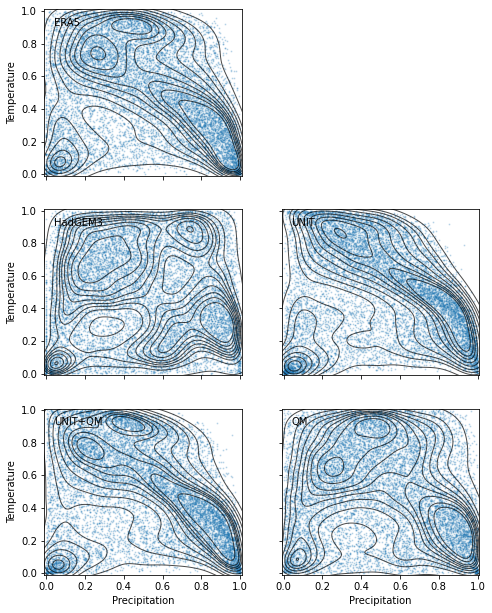

In [55]:
xs = [_transform(ds, tip_india) for ds in all_ds]

plot_vrac(xs, xlabel=r'Precipitation', ylabel=r'Temperature', d=0.01)
plt.savefig("figs/single_location_joint_tip_india_vrac.png", dpi=300)
plt.show()


In [ ]:
plt.figure()

fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)

_plot(x, ax)
    

ax.set_xlabel(r'Precipitation$^{1/4}$')
ax.set_ylabel(r'Temperature')


bins=10
minmaxes = [(x.min(), x.max()) for x in xs[0]]
bin_arrays = [np.linspace(mn, mx, bins+1,endpoint=True) for mn, mx in minmaxes]


ax.vlines(bin_arrays[0], bin_arrays[1][0], bin_arrays[1][-1], 
          color='pink', alpha=.5, zorder=-1)
ax.hlines(bin_arrays[1], bin_arrays[0][0], bin_arrays[0][-1], 
          color='pink', alpha=.5, zorder=-1)

    
plt.show()

## Divergence maps

N.B this calculation has been transfered to the `kl_div_map.py` script

In [401]:
ls -lrt /home/s1205782/netcdf_store/*_map.nc

-rw-rw-r-- 1 s1205782 s1205782 2011467 Nov 28  2021 /home/s1205782/netcdf_store/train_set_kl_map.nc
-rw-rw-r-- 1 s1205782 s1205782 2011467 Nov 28  2021 /home/s1205782/netcdf_store/test_set_kl_map.nc
-rw-rw-r-- 1 s1205782 s1205782 2011467 Jun 30 17:30 /home/s1205782/netcdf_store/test_set_energy_dist_map.nc
-rw-rw-r-- 1 s1205782 s1205782 2011467 Jul 11 14:02 /home/s1205782/netcdf_store/test_set_js_div_map.nc


In [402]:
results_test = xr.load_dataset(f"/home/s1205782/netcdf_store/test_set_js_div_map.nc")

In [403]:
#results_test['dataset'] = ['ERA5', 'HadGEM3', 'UNIT', 'UNIT+QM', 'QM']

In [404]:
results_test

<xarray.Dataset>
Dimensions:  (lat: 68, lon: 92, dataset: 5, bins: 8)
Coordinates:
  * lat      (lat) float32 -7.5 -6.944 -6.389 -5.833 ... 28.06 28.61 29.17 29.72
  * lon      (lon) float32 44.58 45.42 46.25 47.08 ... 117.9 118.8 119.6 120.4
  * dataset  (dataset) object 'ERA5' 'HadGEM3' 'UNIT' 'QM+UNIT' 'QM'
  * bins     (bins) int64 5 10 15 20 30 40 50 100
Data variables:
    js_div   (lat, lon, dataset, bins) float64 0.0 0.0 0.0 ... 0.04765 0.1578

In [405]:
var_name = 'js_div'
var_discription = 'JS divergence'

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


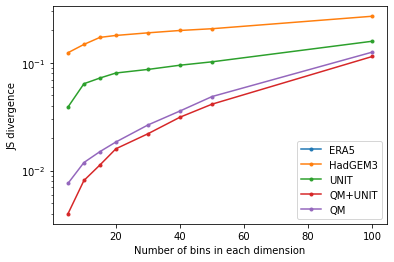

In [406]:
x = results_test[var_name].sel(**locs[tip_india], method='nearest')
for d in x.dataset:
    x.sel(dataset=d).plot(label=d.item(), marker='.')
plt.ylabel(var_discription)
plt.xlabel('Number of bins in each dimension')
plt.yscale('log')
plt.legend()
plt.title('')
plt.show()

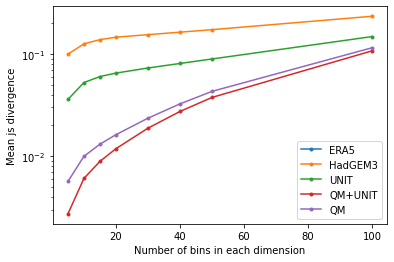

In [407]:
x = results_test[var_name].mean(dim=('lat', 'lon'))
for d in x.dataset:
    x.sel(dataset=d).plot(label=d.item(), marker='.')
plt.ylabel(f'Mean {var_discription.lower()}')
plt.xlabel('Number of bins in each dimension')
plt.yscale('log')
plt.legend()
plt.title('')
plt.show()

In [408]:
div_bins=30

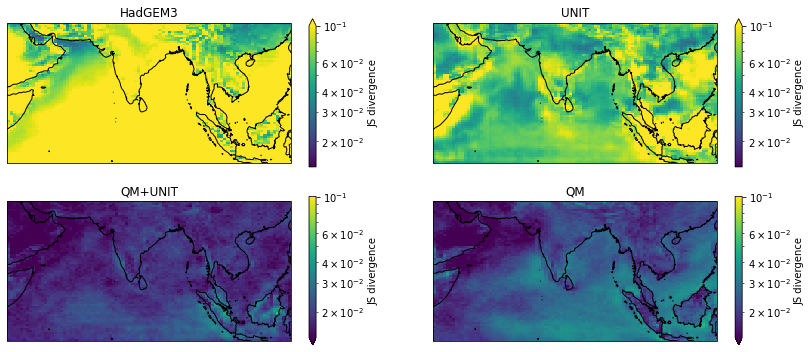

In [425]:
results = results_test[var_name].sel(dataset=slice( 'HadGEM3', None)) #- results_train.kl_div

x_ = results.sel(bins=div_bins).values
vmin, vmax = x_.min(), x_.max()
del x_



fig, axes = plt.subplots(2,2, figsize=(14,6), subplot_kw=dict(projection=projection))
axes = axes.flatten()
for dataset, ax in zip(results.dataset.values, axes):
    results.sel(dataset=dataset, bins=div_bins).plot(ax=ax, vmin=.014, vmax=.1, 
                                                 norm=matplotlib.colors.LogNorm(), 
                                                 cbar_kwargs={'label': var_discription, 
                                                              #'ticks': [.05, .1, .2, .4]
                                                    })    
    ax.set_title(dataset)
    ax.coastlines()
    #ax.plot([this_loc['lon']], [this_loc['lat']], marker='.', color='w')
    trim_plot(results, ax)
#plt.tight_layout()

plt.show()

In [411]:
results_test[var_name].sel(**locs[tip_india], bins=div_bins, method='nearest')

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


<xarray.DataArray 'js_div' (dataset: 5)>
array([0.        , 0.18993166, 0.08690933, 0.0219977 , 0.02653683])
Coordinates:
    lat      float32 8.611
    lon      float32 77.92
  * dataset  (dataset) object 'ERA5' 'HadGEM3' 'UNIT' 'QM+UNIT' 'QM'
    bins     int64 30

### Bootstrap

In [557]:
from kl_div_map import est_js_div
from kl_div_map import transform as js_transform
from cupy.cuda import Device


In [597]:
xs = [js_transform(ds.sel(**locs[tip_india], method='nearest')) for ds in all_ds]

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

In [592]:
def bootstrap_sample(x):
    n = len(x[0])
    inds = np.random.randint(0, n, n)
    return [a.values[inds] for a in x]

def bootstrap_maybe(x, n):
    if n==0:
        return x
    else:
        return bootstrap_sample(x)

In [621]:
boot_results = {}

with Device(2):
    for n in tqdm(range(200)):

        x_ref = bootstrap_maybe(xs[0], n)
        
        for x in xs:
            t = x[0].attrs['title']
            x = bootstrap_maybe(x, n)
            div = est_js_div(x, x_ref, bins=30)
            if t in boot_results.keys():
                boot_results[t] += [div]
            else:
                boot_results[t] = [div]

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 55.04it/s]


In [622]:
{k:v[0] for k, v in boot_results.items()}

{'ERA5': 0.0,
 'HadGEM3': 0.1899316596660809,
 'UNIT': 0.08690932521615995,
 'UNIT+QM': 0.021997700777012727,
 'QM': 0.026536826455638086}

In [623]:
results_test[var_name].sel(**locs[tip_india], bins=div_bins, method='nearest')

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


<xarray.DataArray 'js_div' (dataset: 5)>
array([0.        , 0.18993166, 0.08690933, 0.0219977 , 0.02653683])
Coordinates:
    lat      float32 8.611
    lon      float32 77.92
  * dataset  (dataset) object 'ERA5' 'HadGEM3' 'UNIT' 'QM+UNIT' 'QM'
    bins     int64 30

In [624]:
def pretty_print_bounds(v):
    low, median, high = np.quantile(v, [.05, 0.5, .95])
    
    return f"{v[0]:.4f} ({low:.4f}|{median:.4f}|{high:.4f})"
{k:pretty_print_bounds(v) for k, v in boot_results.items()}

{'ERA5': '0.0000 (0.0099|0.0112|0.0123)',
 'HadGEM3': '0.1899 (0.1942|0.1987|0.2045)',
 'UNIT': '0.0869 (0.0908|0.0944|0.0982)',
 'UNIT+QM': '0.0220 (0.0296|0.0319|0.0342)',
 'QM': '0.0265 (0.0349|0.0372|0.0400)'}

## 1D temp range

In [161]:
locs.keys()

dict_keys(['Southern tip of India', 'other', 'other2', 'Sumatra', 'Arabian Sea'])

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureW

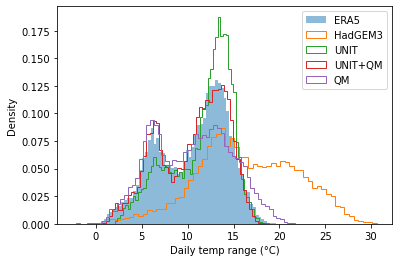

In [173]:
fig, ax = plt.subplots(1,1)

this_loc = (21, 79) # middle of indian continent

def select_loc(ds, loc):
    if isinstance(loc, str):
        return select_named_loc(ds, loc)
    return ds.sel(lat=loc[0], lon=loc[1], method='nearest')

for ds in all_ds:
    histtype='stepfilled' if ds.attrs['title']=='ERA5' else 'step'
    alpha = 0.5 if ds.attrs['title']=='ERA5' else 1
    da = select_loc(ds, this_loc).tasmax - select_loc(ds, this_loc).tasmin
    da.plot.hist(
        bins=60, label=ds.attrs['title'], 
        density=True, alpha=alpha, 
        histtype=histtype, ax=ax, 
    )
plt.legend()#loc='upper left')
plt.title(None)
plt.xlabel('Daily temp range (°C)')
plt.ylabel('Density')
#plt.ylim(0, 50)
plt.show()

## Seasonality

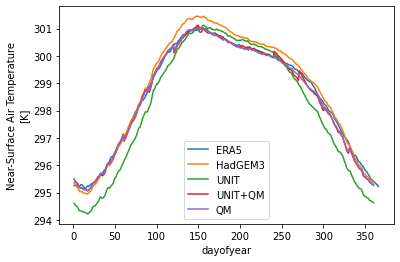

In [183]:
fig, ax = plt.subplots(1,1)

this_loc = (21, 79) # middle of indian continent

def select_loc(ds, loc):
    if isinstance(loc, str):
        return select_named_loc(ds, loc)
    return ds.sel(lat=loc[0], lon=loc[1], method='nearest')

for ds in all_ds:
    da = ds.tas.groupby('time.dayofyear').mean(dim=('time','lat', 'lon'))
    da.plot(label=ds.attrs['title'], ax=ax, 
    )
plt.legend()#loc='upper left')
plt.title(None)
#plt.xlabel('Daily temp range (°C)')
#plt.ylabel('Density')
#plt.ylim(0, 50)
plt.show()

## Autocorrelation

In [ ]:
def daymean(arr, window=5):
    def identity_(x, axis=None):
        return x
    return (
        arr.rolling(time=window, center=True).reduce(identity_)
        .groupby('time.dayofyear').mean(dim=('time', '_rolling_dim_time', 'run'))
    )

def daystd(arr, window=5):
    def identity_(x, axis=None):
        return x
    return (
        arr.rolling(time=window, center=True).reduce(identity_)
        .groupby('time.dayofyear').std(dim=('time', '_rolling_dim_time', 'run'))
    )

def daynorm(arr, window=5, trend_window=360):

    trend = arr.rolling(time=trend_window, center=True).mean(dim='time')
    arr = arr - trend
    
    arr_mean = daymean(arr, window=window)
    arr = arr.groupby('time.dayofyear') - arr_mean
    
    arr_std = daystd(arr, window=window)
    return (arr.groupby('time.dayofyear')/arr_std).drop('dayofyear')


In [140]:
ds_norm = daynorm(all_ds[1].isel(time=slice(0, 360*10)), window=5)

In [141]:
x = ds_norm
y = ds_norm.shift(time=1)
corrs = (x*y).mean(dim='time')

In [145]:
variable = 'z500'

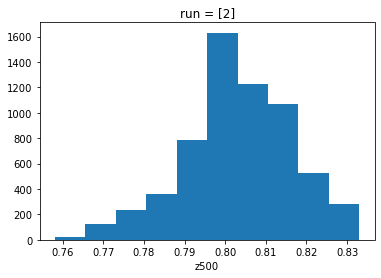

In [146]:
corrs[variable].plot.hist()
plt.show()

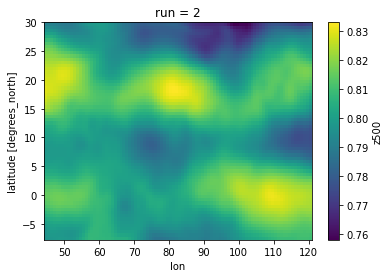

In [148]:
corrs[variable].plot()
plt.show()

# Find minimum pressure systems

In [379]:
def spatial_demean(da, da_ref):
    return (da.groupby('time.month') - da_ref.groupby('time.month').mean(dim='time')).drop('month')

In [380]:
def find_pressure_systems(da_z500, n, nlat=10, nlon=10, kind='min'):
    print('de-meaning')
    da_z500 = spatial_demean(da_z500, da_z500)
    print('rolling')
    rolling_mean = da_z500.rolling(lat = nlat).mean().rolling(lon=nlon).mean()
    if kind=='min':
        f = rolling_mean.min
    elif kind=='max':
        f = rolling_mean.max
    elif kind=='minmax':
            f = np.abs(rolling_mean).max
    print('searching')
    times = f(dim=tuple(x for x in list(da_z500.coords) if x!='time')) \
        .to_dataframe(name='z500') \
        .nlargest(n, columns='z500') \
        .index
    return times

In [381]:
def plot_variables_on_dates(dates, variables, variable_transforms):
    for date in dates:
        fig, axes = plt.subplots(len(variables), 4, figsize=(16,6))
        date_ds = [ds.isel(run=0).sel(time=date) for ds in [ds_base, ds_trans, ds_transqm, ds_qm]]
        
        for i, (variable, transform) in enumerate(zip(variables, variable_transforms)):
            var_ds = [transform(ds[variable]) for ds in date_ds]
            vmin, vmax = common_min_max(var_ds)
                   
            cmap = cmocean.cm.rain if variable=='pr' else cmocean.cm.thermal
                   
            for ds, ax in zip(var_ds, axes[i]):
                ds.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
                ax.set_title(ds.attrs['title'])
        plt.tight_layout()
        plt.show()

In [382]:
# min pressure systems in monsoon season
min_pressure_system_times = find_pressure_systems(
    select_months(ds_base.z500, [6, 7, 8, 9], drop=True), 
    n=5, nlat=10, nlon=10, kind='min'
)

de-meaning
rolling
searching


In [383]:
min_pressure_system_times

CFTimeIndex([2002-08-30 12:00:00, 2010-06-02 12:00:00, 1994-09-24 12:00:00,
             1997-08-14 12:00:00, 2005-08-25 12:00:00],
            dtype='object', length=5, calendar='360_day', freq='None')

In [ ]:
plot_variables_on_dates(min_pressure_system_times, 
                        variables=['z500','pr', 'tas'], 
                        variable_transforms=[
                            lambda x: x,
                            lambda x: clip(x, None, 75)**.25,
                            lambda x: x,
                        ]
)

In [385]:
results = []
with ProgressBar(dt=10):
    for ds in [ds_target, ds_trans, ds_base]:
        results.append(
            select_months(ds.pr.isel(run=0).clip(0,None), [6, 7, 8, 9], drop=True)
            .mean(dim='time')
            .compute()
        )

[########################################] | 100% Completed |  1min  0.3s
[########################################] | 100% Completed | 30.1s
[########################################] | 100% Completed | 30.1s


In [ ]:
land_mask = False



plt.figure(figsize=(12,4))

axes = [plt.subplot(231+i, projection=projection) for i in [0,1,2,4,5]]

def rename_sub(dsa, dsb):
    ds = dsa-dsb
    ds.attrs['title'] = f"{dsa.attrs['title']} - {dsb.attrs['title']}"
    return ds
        
datasets = results+[rename_sub(r,results[0]) for r in results[1:]]


abs_range = 0, 20# range_multi(results)
dif_range = -20, 20#range_multi(datasets[-2:])


vmins = [abs_range[0]]*3+[dif_range[0]]*2#[-max(np.abs(dif_range))]*2
vmaxs = [abs_range[1]]*3+[dif_range[1]]*2#[max(np.abs(dif_range))]*2
cmaps=[cmocean.cm.rain]*3+[cmocean.cm.balance_r]*2
norms = [None]*3 + [colors.TwoSlopeNorm(vmin=vmins[-1], vmax=vmaxs[-1], vcenter=0)]*2

i=0
for da, ax, vmin, vmax, norm, cmap in zip(datasets, axes, vmins, vmaxs, norms, cmaps):
    lon_range = lat_lon_range(da.lon)
    lat_range = lat_lon_range(da.lat)
    cbar_kwargs = dict(label=f"Precipitation" if i<3 else f"$\Delta$ Precipitation")
    if land_mask:
        da.where(get_land_mask(da)[0]).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, 
                                            norm=norm, cbar_kwargs=cbar_kwargs)
    else:
        da.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, norm=norm, cbar_kwargs=cbar_kwargs)
    ax.coastlines(alpha=0.5)
    ax.set_title(da.attrs['title'])
    ax.set_xlim(*lon_range)
    ax.set_ylim(*lat_range)
    i+=1
    
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('figs/monsoon_rain_bias_maps.png', dpi=300)
plt.show()

# What do the pressure systems look like when it rains in monsoon months?


We'll be looking for rain in the highlighted region in the plot below

In [ ]:
def get_land(ds):
    return ds.where(get_land_mask(ds)[0]).where((ds.lon>68)&(ds.lon<90)&(ds.lat<22))

ax = plt.subplot(111, projection=projection)
get_land(ds_base['pr'].isel(time=0, run=0)).clip(1,1).plot(ax=ax)
ax.coastlines()
plt.show()

Find the days in the monsoon season which have the highest rainfall over the land area above. Take the top 20% and take the mean over those

In [ ]:
ds_rainy_list = []

for ds in all_ds:
    ds = ds.isel(run=0)
    ds = select_months(ds, [6, 7, 8, 9], drop=True)
    land_precip = get_land(ds).pr.mean(dim=('lat', 'lon'))
    rainy_times = land_precip.to_dataframe().nlargest(int(0.2*len(ds.time)), columns='pr').index
    ds_rainy_list += [ds.sel(time=rainy_times).mean(dim='time')]
    

In [ ]:
variables = ['pr', 'z500']
cmaps = [cmocean.cm.rain, cmocean.cm.thermal]


fig, axes = plt.subplots(2, 5, subplot_kw=dict(projection=projection), figsize=(16,3.5))

lon_range = lat_lon_range(ds_rainy_list[0].lon)
lat_range = lat_lon_range(ds_rainy_list[0].lat)

for r, v in enumerate(variables):
    vmin, vmax = common_min_max([ds[v] for ds in ds_rainy_list])
    cmap = cmaps[r]
    
    for i, ds in enumerate(ds_rainy_list):
                                               
        ax = axes[r, i]

        ds[v].plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(ds.attrs['title'])

        ax.set_xlim(*lon_range)
        ax.set_ylim(*lat_range)
        ax.coastlines(alpha=0.5)


plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

In [ ]:
variables = ['pr', 'z500']
cmaps = [cmocean.cm.rain, cmocean.cm.thermal]
minmaxes = [(-10, 10), (-5, 5)]

fig, axes = plt.subplots(2, 5, subplot_kw=dict(projection=projection), figsize=(16,3.5))

lon_range = lat_lon_range(ds_rainy_list[0].lon)
lat_range = lat_lon_range(ds_rainy_list[0].lat)

for r, v in enumerate(variables):
    cmap = cmaps[r]
    
    vmin, vmax = minmaxes[r]
    for i, ds in enumerate(ds_rainy_list):
                                               
        ax = axes[r, i]
        
        
        (ds_rainy_list[0][v] - ds[v]).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='BrBG')
        ax.set_title(ds.attrs['title'])

        ax.set_xlim(*lon_range)
        ax.set_ylim(*lat_range)
        ax.coastlines(alpha=0.5)


plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

In [ ]:
def transform(ds, loc_string, loc_string2=None):
    x = ds.isel(run=0).sel(**locs[loc_string], method='nearest').pr.clip(None, 75)**.25
    if loc_string2 is None:
        ilat = np.where(ds.lat.values == x.lat.item())[0].item()
        ilon = np.where(ds.lon.values == x.lon.item())[0].item()
        y = ds.isel(run=0, lat=ilat, lon=ilon+1).pr.clip(None, 75)**.25
    else:
        y = ds.isel(run=0).sel(**locs[loc_string2], method='nearest').pr.clip(None, 75)**.25
    return x, y 

In [ ]:
this_loc

In [ ]:
xs[0]

In [ ]:
xs = [transform(ds, this_loc) for ds in all_ds]
print(this_loc)
x,y = xs[0]
print(x.lat.item(), x.lon.item(), y.lat.item(), y.lon.item())

plt.figure()
s=1.3
fig, axes = plt.subplots(3,2, figsize=(6*s,8*s), sharex=True, sharey=True)

def _plot(x, ax):
    ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
    #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
    ax.annotate(x[1].attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
    sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )

for x, ax in zip(xs, axes.flatten()[[0,2,3,4,5]]):
    _plot(x, ax)
    
for ax in axes[-1,:]:
    ax.set_xlabel(r'Precipitation$^{1/4}$')
for ax in axes[:,0]:
    ax.set_ylabel('Neighbouring\nprecipitation$^{1/4}$')
    
axes[0, -1].axis('off')

plt.show()

# Spatial matching

This calulcation has been moved to the `spatial_match.py` script.

In [11]:
ls -rt /home/s1205782/netcdf_store/*spatial_match*

/home/s1205782/netcdf_store/train_set_era_to_other_spatial_match.nc
/home/s1205782/netcdf_store/train_set_other_to_era_spatial_match.nc
/home/s1205782/netcdf_store/test_set_other_to_era_spatial_match.nc
/home/s1205782/netcdf_store/test_set_era_to_other_spatial_match.nc
/home/s1205782/netcdf_store/test_set_era_to_other_spatial_match_v2.nc
/home/s1205782/netcdf_store/test_set_baseline_spatial_match_v2.nc
/home/s1205782/netcdf_store/test_set_other_to_era_spatial_match_v2.nc


In [12]:
results_root = "/home/s1205782/netcdf_store/test_set"

In [13]:
era_match_ds = xr.open_dataset(f"{results_root}_era_to_other_spatial_match_v2.nc")
other_match_ds = xr.open_dataset(f"{results_root}_other_to_era_spatial_match_v2.nc")
base_match_ds = xr.open_dataset(f"{results_root}_baseline_spatial_match_v2.nc")

In [14]:
era_match_ds

<xarray.Dataset>
Dimensions:      (match_to: 4, sample_from: 1, match_func: 3, variable: 4, timestep: 12782)
Coordinates:
  * match_to     (match_to) object 'HadGEM3' 'UNIT' 'UNIT+QM' 'QM'
  * sample_from  (sample_from) object 'ERA5'
  * match_func   (match_func) object 'ssim_best_match' ... 'mae_best_match'
  * variable     (variable) object 'pr' 'z500' 'tas' 'pr+z500+tas'
  * timestep     (timestep) int64 0 1 2 3 4 5 ... 12777 12778 12779 12780 12781
Data variables:
    values       (match_to, sample_from, match_func, variable, timestep) float64 ...
    positions    (match_to, sample_from, match_func, variable, timestep) float64 ...

In [15]:
def dict_replace(arr, subs):
    return [subs[x] if x in subs.keys() else x for x in arr]

var_to_displayname = {
    'pr':'Precipitation$^{1/4}$', 
    'z500':'500hPa geopotential height', 
    'tas':'Temperature',
    'pr+z500+tas':'All three variables',
}

var_to_varname = {v:k for k,v in var_to_displayname.items()}

func_subs = {'ssim_best_match':'SSIM', 'mse_best_match':'MSE', 'mae_best_match':'MAE'}
match_subs = {'QM+UNIT':'UNIT+QM',} # correct a naming mistake from previously


fields = {
    'ERA5':ds_target,
    'HadGEM3':ds_base,
    'UNIT':ds_trans,
    'UNIT+QM':ds_transqm,
    'QM':ds_qm,
}

variable_transforms = {
    'pr': lambda da: da.clip(0, None)**.25,
    'z500': lambda da: da,
    'tas': lambda da: da,
}

def rename(ds):
    
    ds['variable'] = dict_replace(ds['variable'].values, var_to_displayname)
    ds['match_func'] = dict_replace(ds['match_func'].values, func_subs)
    ds['match_to'] = dict_replace(ds['match_to'].values, match_subs)
    ds['sample_from'] = dict_replace(ds['sample_from'].values, match_subs)
    return ds


other_match_ds = rename(other_match_ds)
era_match_ds = rename(era_match_ds)
base_match_ds = rename(base_match_ds)

In [16]:
base_match_ds

<xarray.Dataset>
Dimensions:      (match_to: 1, sample_from: 1, match_func: 3, variable: 4, timestep: 12600)
Coordinates:
  * match_to     (match_to) <U13 'HadGEM3_other'
  * sample_from  (sample_from) <U7 'HadGEM3'
  * match_func   (match_func) <U4 'SSIM' 'MSE' 'MAE'
  * variable     (variable) <U26 'Precipitation$^{1/4}$' ... 'All three varia...
  * timestep     (timestep) int64 0 1 2 3 4 5 ... 12595 12596 12597 12598 12599
Data variables:
    values       (match_to, sample_from, match_func, variable, timestep) float64 ...
    positions    (match_to, sample_from, match_func, variable, timestep) float64 ...

In [17]:
era_match_ds

<xarray.Dataset>
Dimensions:      (match_to: 4, sample_from: 1, match_func: 3, variable: 4, timestep: 12782)
Coordinates:
  * match_to     (match_to) <U7 'HadGEM3' 'UNIT' 'UNIT+QM' 'QM'
  * sample_from  (sample_from) <U4 'ERA5'
  * match_func   (match_func) <U4 'SSIM' 'MSE' 'MAE'
  * variable     (variable) <U26 'Precipitation$^{1/4}$' ... 'All three varia...
  * timestep     (timestep) int64 0 1 2 3 4 5 ... 12777 12778 12779 12780 12781
Data variables:
    values       (match_to, sample_from, match_func, variable, timestep) float64 ...
    positions    (match_to, sample_from, match_func, variable, timestep) float64 ...

In [102]:
def convenience_transposer(ds):
    ds = ds.copy()
    match_longer = len(ds.match_to) > len(ds.sample_from)
    long = 'match_to' if match_longer else 'sample_from'
    short = 'sample_from' if match_longer else 'match_to'

    ds['long'] = ds[long]
    ds['short'] = ds[short]
    
    ds = ds.swap_dims({long:'long', short:'short'}).drop([long, short])
    return ds

## Other datasets match to ERA

In [91]:
def match_value_distributions(ds, funcs='all', base_ds=None):
    if funcs=='all':
        funcs = ds.match_func.values
    
    ds = convenience_transposer(ds)
    if base_ds is not None:
        base_ds = convenience_transposer(base_ds)
    
    for func in funcs:
        
        fig, axes = plt.subplots(2,2, figsize=(8,8))
        for i, (var, ax) in enumerate(zip(ds.variable.values, axes.flatten())):

            next(ax._get_lines.prop_cycler) # skip first color saved for ERA

            df = ds['values'] \
                .isel(short=0, drop=True) \
                .sel(match_func=func, variable=var, drop=True) \
                .to_dataset('long') \
                .to_dataframe()
            
            if base_ds is not None:
                base_df = base_ds['values'] \
                    .isel(short=0, drop=True) \
                    .sel(match_func=func, variable=var, drop=True) \
                    .to_dataset('long') \
                    .to_dataframe()
                df['Base'] = base_df.iloc[:,0]
            
            vmin, vmax = np.percentile(df.values.flatten(), [0, 99.9])

            for col in df.columns:
                extra_kwargs = dict(zorder=-1, color='k') if col=='Base' else dict()
                df[col].clip(vmin, vmax).hist(bins=100, grid=0, 
                                              histtype='step', ax=ax, alpha=1, label=col,
                                              **extra_kwargs
                )
            ax.set_xlabel(func)
            ax.set_ylabel('counts')

            ax.set_title(var)
            if i==0:
                ax.legend(loc='best')
        plt.tight_layout()
        if len(ds.variable.values)==3:
            axes[1,1].axis('off')
        plt.show()


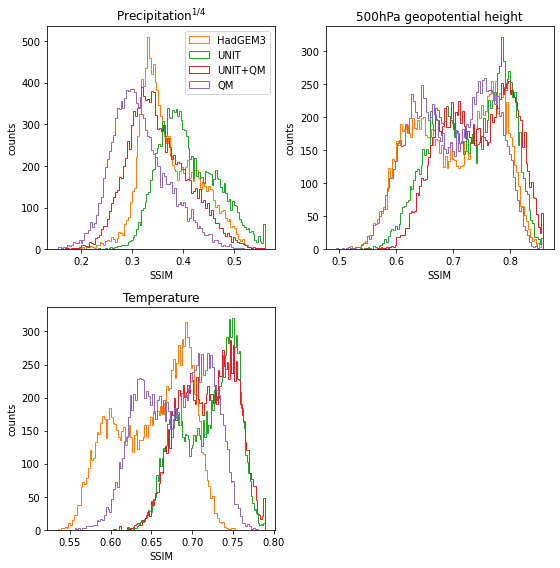

In [95]:
match_value_distributions(other_match_ds.isel(variable=slice(0,3)), ['SSIM'])

## ERA match to others

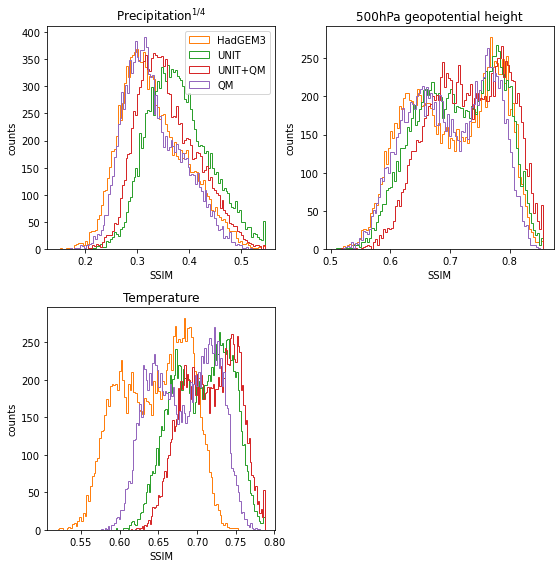

In [96]:
match_value_distributions(era_match_ds.isel(variable=slice(0,3)), ['SSIM'])

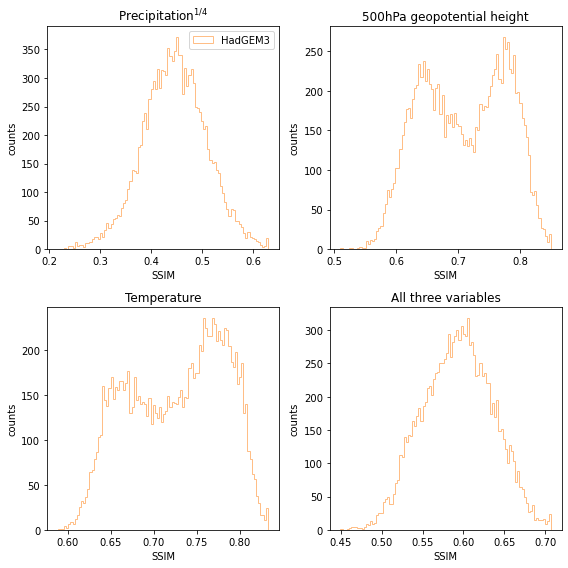

In [642]:
match_value_distributions(base_match_ds, ['SSIM'])

## ERA match to others paper appendix

In [97]:
def match_value_distributions_appendix(ds, opposite_ds):
    func='SSIM'
    
    ds = convenience_transposer(ds)
    opp_ds = convenience_transposer(opposite_ds)
    
        
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    for i, (var, ax) in enumerate(zip(ds.variable.values, axes.flatten())):

        next(ax._get_lines.prop_cycler) # skip first color saved for ERA

        df = ds['values'] \
            .isel(short=0, drop=True) \
            .sel(match_func=func, variable=var, drop=True) \
            .to_dataset('long') \
            .to_dataframe()

        vmin, vmax = np.percentile(df.values.flatten(), [0, 99.9])

        for col in df.columns:
            extra_kwargs = dict(zorder=-1, color='k') if col=='Base' else dict()
            df[col].clip(vmin, vmax).hist(bins=100, grid=0, 
                                          histtype='step', ax=ax, alpha=1, label=col,
                                          **extra_kwargs
            )
        ax.set_xlabel(func)
        ax.set_ylabel('counts')

        ax.set_title(var)
        if i==0:
            ax.legend(loc='best')
    plt.tight_layout()
    
    if len(ds.variable.values)==3:
        
        ax = axes[1,1]
        
        next(ax._get_lines.prop_cycler) # skip first color saved for ERA
        next(ax._get_lines.prop_cycler) # skip first color saved for HadGEM
        unit_col = next(ax._get_lines.prop_cycler)['color']
        unitqm_col = next(ax._get_lines.prop_cycler)['color']
        
        df = ds['values'] \
            .isel(short=0, drop=True) \
            .sel(match_func=func, drop=True) \
            .isel(variable=0) \
            .to_dataset('long') \
            .to_dataframe()
            
        df = df.loc[:, ['UNIT', 'UNIT+QM']]
            
        opp_df = opp_ds['values'] \
            .isel(short=0, drop=True) \
            .sel(match_func=func, drop=True) \
            .isel(variable=0) \
            .to_dataset('long') \
            .to_dataframe()
            
        

        vmin, vmax = np.percentile(df.values.flatten(), [0, 99.9])

        for col, color in list(zip(df.columns, [unit_col, unitqm_col]))[::-1]:
            df[col].clip(vmin, vmax).hist(bins=100, grid=0, 
                                          histtype='step', ax=ax, label=r'ERA$\rightarrow$'+col,
                                          color=color,
            )
            opp_df[col].clip(vmin, vmax).hist(bins=100, grid=0, 
                                          histtype='step', ax=ax, #label=col+r'$\rightarrow$ERA',
                                          color=color, alpha=.5,
            )
        ax.set_xlabel(func)
        ax.set_ylabel('counts')

        ax.set_title(f"Match direction comparison - {ds.variable.values[0]}")
        ax.legend(loc='upper left', framealpha=0)#, fontsize="small")
        
        
    plt.show()


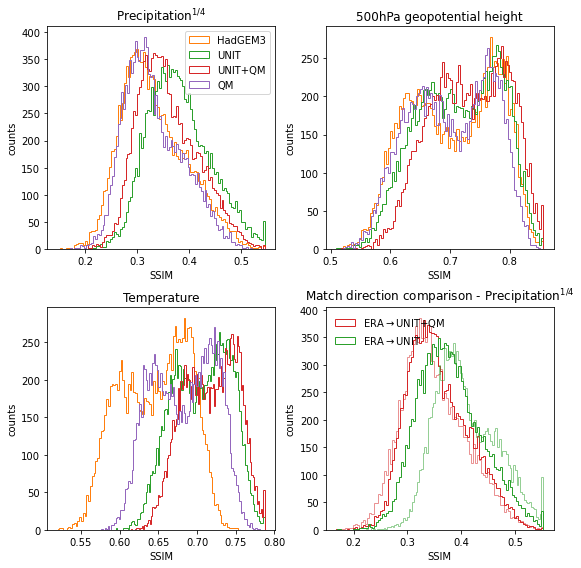

In [98]:
match_value_distributions_appendix(era_match_ds.isel(variable=slice(0, 3)), other_match_ds)

## Diversity of best match

Do all of the fields from dataset X match to a small set of fields in dataset Y?

In [670]:
def field_match_frequency(ds, func, base_ds=None, bins=None):
    
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    if len(ds['variable'].values)==3:
        axes[1,1].axis('off')

    ds = convenience_transposer(ds).sel(match_func=func)
    
    def plot(x, ax, label, **plot_kwargs):
        indexes, counts = np.unique(x, return_counts=True)
        counts = np.sort(counts)[::-1]
        field_number = np.arange(1,counts.shape[0]+1)
        ax.plot(field_number, counts, label=label, marker='.', linestyle='-', markersize=4, **plot_kwargs)

    for var, ax in zip(ds['variable'].values, axes.flatten()):
        
        next(ax._get_lines.prop_cycler) # skip first color saved for ERA
        
        da = ds['positions'].sel(variable=var)

        for y in da.long.values:
            x = da.sel(long=y)
            plot(x, ax, label=y)
            
        if base_ds is not None:
            x = base_ds['positions'].sel(variable=var, match_func=func).values.squeeze()
            plot(x, ax, label='Base', color='k', zorder=-1)
        
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel(f'Rank of field')
        ax.set_ylabel(f'Number of matches')
        ax.set_title(var)
    
    axes[0,0].legend()
    plt.tight_layout()

    
def fields_per_match_frequency(ds, func, base_ds=None, bins=None):
    
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    if len(ds['variable'].values)==3:
        axes[1,1].axis('off')

    ds = convenience_transposer(ds).sel(match_func=func)
    
    def plot(x, ax, label, **plot_kwargs):
        _, counts = np.unique(x, return_counts=True)
        counts, matches_with_count = np.unique(counts, return_counts=True)
        ax.plot(counts, matches_with_count, marker='.', linestyle='-', markersize=4, label=label, **plot_kwargs)

    for var, ax in zip(ds['variable'].values, axes.flatten()):
        
        next(ax._get_lines.prop_cycler) # skip first color saved for ERA
        
        da = ds['positions'].sel(variable=var)

        for y in da.long.values:
            x = da.sel(long=y)
            plot(x, ax, label=y)
            
        if base_ds is not None:
            x = base_ds['positions'].sel(variable=var, match_func=func).values.squeeze()
            plot(x, ax, label='Base', color='k', zorder=-1)
        
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel(f'Number of matches to field')
        ax.set_ylabel(f'Number of fields with match count')
        ax.set_title(var)
    
    axes[0,0].legend()
    plt.tight_layout()

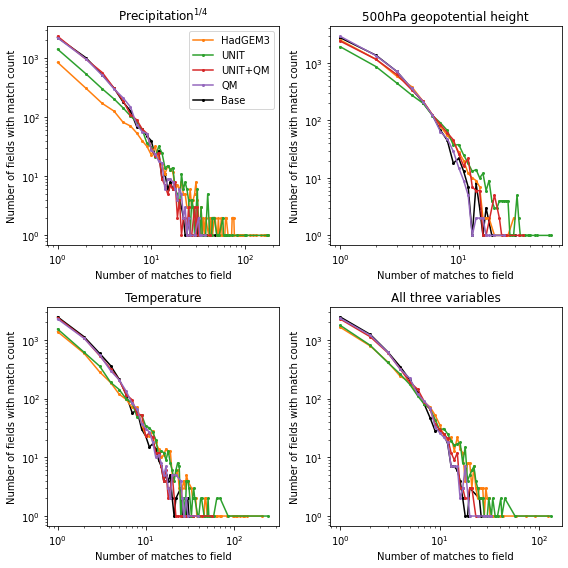

In [671]:
fields_per_match_frequency(other_match_ds, func='SSIM', base_ds=base_match_ds)

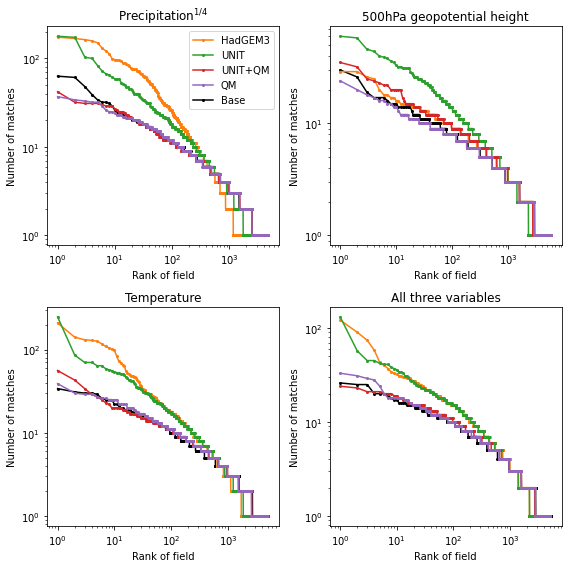

In [672]:
field_match_frequency(other_match_ds, func='SSIM', base_ds=base_match_ds)

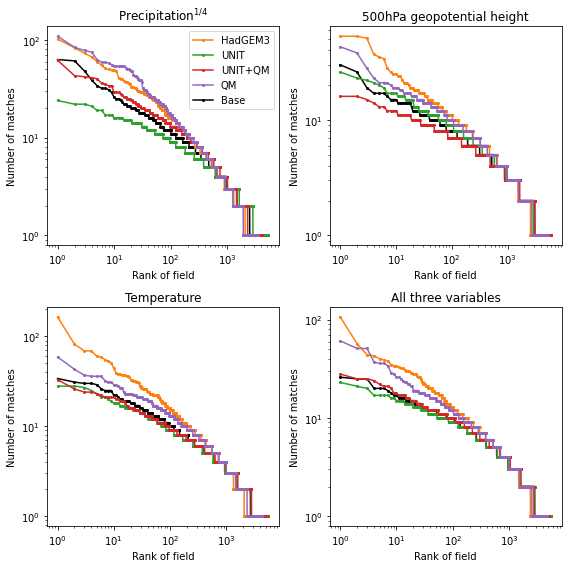

In [673]:
field_match_frequency(era_match_ds, func='SSIM', base_ds=base_match_ds)

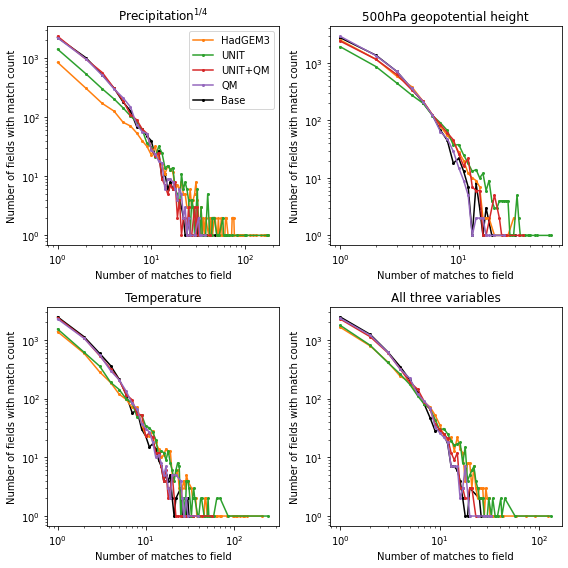

In [674]:
fields_per_match_frequency(other_match_ds, func='SSIM', base_ds=base_match_ds)

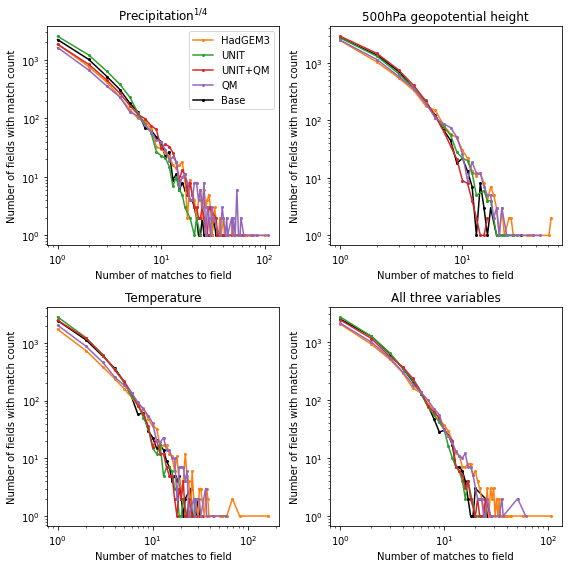

In [676]:
fields_per_match_frequency(era_match_ds, func='SSIM', base_ds=base_match_ds)

In [677]:
def direct_of_match_comparison(era_match_ds, other_match_ds, func, variable, base_ds=None):
    
    fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
    
    def this_sel(ds):
        return convenience_transposer(ds).sel(variable=variable, match_func=func).isel(short=0)
    
    era_match_ds = this_sel(era_match_ds)
    other_match_ds = this_sel(other_match_ds)
    if base_ds is not None:
        base_da = this_sel(base_ds).isel(long=0).positions

    for datasource, ax in zip(era_match_ds.long.values, axes.flatten()):
        other_match_da = other_match_ds.sel(long=datasource).positions
        era_match_da = era_match_ds.sel(long=datasource).positions
        

        fraction_matched_to = []
        for matchfrom, matchto, da in [
            (datasource, 'ERA5', other_match_da), 
            ('ERA5', datasource, era_match_da)
        ]:
            _, counts = np.unique(da, return_counts=True)
            counts = np.sort(counts)[::-1]
            freqs = counts/counts.sum()
            field_number = np.arange(1,freqs.shape[0]+1)
            label = matchfrom + r"$\rightarrow$" + matchto
            ax.plot(field_number, freqs, label=label, marker='.', linestyle='-', markersize=4)
            fraction_matched_to += [(label, len(freqs)/len(fields[matchto].time))]
            
        if base_ds is not None:
            _, counts = np.unique(base_da, return_counts=True)
            counts = np.sort(counts)[::-1]
            freqs = counts/counts.sum()
            field_number = np.arange(1,freqs.shape[0]+1)
            label =  r"Base"
            ax.plot(field_number, freqs, label=label, zorder=-1,
                    marker='.', linestyle='-', markersize=4, color='k')
            fraction_matched_to += [(label, len(freqs)/len(fields[matchto].time))]

            
        s = "Fraction of fields \nmatched to:"
        for label, fraction in fraction_matched_to:
            s+=f"\n  {label} : {fraction:.3f}"
        ax.annotate(s, xy=(0.6, 0.05), xycoords='axes fraction', ha='right')

                
        ax.legend(title=r'Match')
        ax.set_yscale('log')
        
        ax.set_xscale('log')
        ax.set_xlabel(f'Field number')
        ax.set_ylabel(f'Fraction matched from')
        ax.set_title(datasource)
    plt.tight_layout()

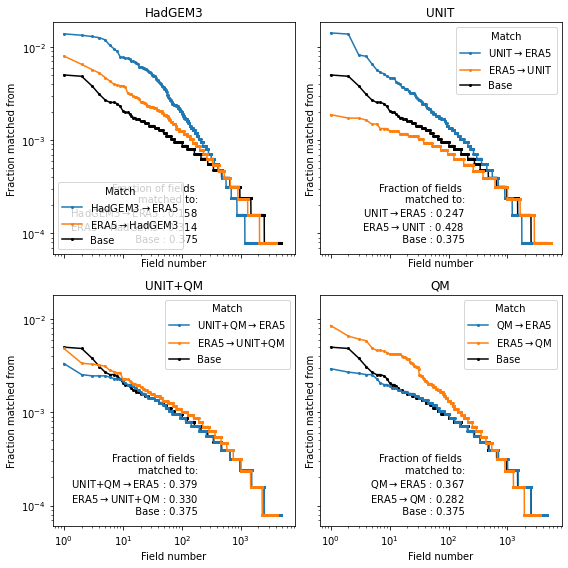

In [678]:
direct_of_match_comparison(
    era_match_ds, 
    other_match_ds, 
    base_ds = base_match_ds,
    func='SSIM', 
    variable='Precipitation$^{1/4}$',
)

In the figure above, match from means the data source we matched from. If the ERA line is higher it means that ERA matched to a less diverse set in the datasource. If the datasource line is higher it means that the datasource matched to a less diverse set of ERA points.

The UNIT fields matched to a much less diverse set of ERA fields

The HadGEM fields matches to a less diverse set of ERA fields

The ERA fields matched to a less diverse set of QM fields

The UNIT+QM fields matches to a diverse set, but there were a few ERA fields that many were matched to.

In [716]:
def direct_of_match_comparison2(era_match_ds, other_match_ds, func, variable, base_ds=None):
    
    fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
    
    def this_sel(ds):
        return convenience_transposer(ds).sel(variable=variable, match_func=func).isel(short=0)
    
    def plot(x, ax, label, **plot_kwargs):
        _, counts = np.unique(x, return_counts=True)
        counts, matches_with_count = np.unique(counts, return_counts=True)
        ax.plot(counts, matches_with_count, marker='.', linestyle='-', markersize=4, label=label, **plot_kwargs)
    
    era_match_ds = this_sel(era_match_ds)
    other_match_ds = this_sel(other_match_ds)
    if base_ds is not None:
        base_da = this_sel(base_ds).isel(long=0).positions

    for datasource, ax in zip(era_match_ds.long.values, axes.flatten()):
        other_match_da = other_match_ds.sel(long=datasource).positions
        era_match_da = era_match_ds.sel(long=datasource).positions
        

        fraction_matched_to = []
        for matchfrom, matchto, da in [
            (datasource, 'ERA5', other_match_da), 
            ('ERA5', datasource, era_match_da)
        ]:
            _, counts = np.unique(da, return_counts=True)
            counts = np.sort(counts)[::-1]
            freqs = counts/counts.sum()
            field_number = np.arange(1,freqs.shape[0]+1)
            
            label = matchfrom + r"$\rightarrow$" + matchto
            plot(da, ax, label)
            #ax.plot(field_number, freqs, label=label, marker='.', linestyle='-', markersize=4)
            fraction_matched_to += [(label, len(freqs)/len(fields[matchto].time))]
            
        if base_ds is not None:
            _, counts = np.unique(base_da, return_counts=True)
            counts = np.sort(counts)[::-1]
            freqs = counts/counts.sum()
            field_number = np.arange(1,freqs.shape[0]+1)
            label =  r"Base"
            plot(base_da, ax, label, zorder=10, color='k')
            fraction_matched_to += [(label, len(freqs)/len(fields[matchto].time))]

            
        s = "Fraction of fields \nmatched to:"
        for label, fraction in fraction_matched_to:
            s+=f"\n  {label} : {fraction:.3f}"
        ax.annotate(s, xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')

                
        ax.legend(framealpha=0, loc='lower left')#title=r'Match')
        ax.set_yscale('log')
        
        ax.set_xscale('log')
        ax.set_xlabel(f'Match count')
        ax.set_ylabel(f'Number of fields with match count')
        ax.set_title(datasource)
    plt.tight_layout()

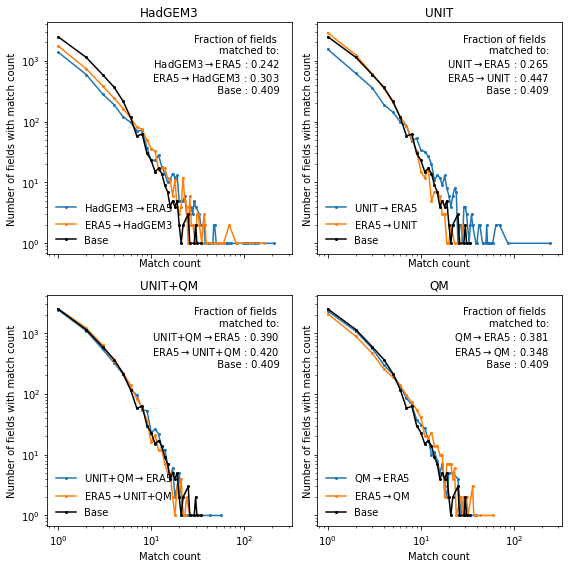

In [728]:
direct_of_match_comparison2(
    era_match_ds, 
    other_match_ds, 
    base_ds = base_match_ds,
    func='SSIM', 
    variable=var_to_displayname['tas'],#'Precipitation$^{1/4}$',
)

In [726]:
var_to_displayname.keys()

dict_keys(['pr', 'z500', 'tas', 'pr+z500+tas'])

## Examine the most matched to fields

In [98]:
import scipy

def mode(*args, **kwargs):
    return scipy.stats.mode(*args, **kwargs).mode

era_match_modes = xr.apply_ufunc(
    mode, 
    era_match_ds.positions,
    input_core_dims=[['timestep']],
    vectorize=True
)

other_match_modes = xr.apply_ufunc(
    mode, 
    other_match_ds.positions,
    input_core_dims=[['timestep']],
    vectorize=True
)

In [193]:

def plot_most_matched(ds, func, variable):
    fig, axes = plt.subplots(2,2, figsize=(14,6), subplot_kw=dict(projection=projection))
    axes = axes.flatten()
    these_fields = []
    
    for val in ds.sel(match_func=func, variable=var_to_displayname[variable]):
        field = fields[val.match_to.item()][variable].isel(time=int(val.item()))
        field.attrs['index'] = int(val.item())
        field.attrs['from'] = val.sample_from.item()
        field.attrs['to'] = val.match_to.item()
        these_fields += [variable_transforms[variable](field)]
    
    vmin, vmax = common_min_max(these_fields)
    
    for field, ax in zip(these_fields, axes):
        field.plot(ax=ax, vmin=vmin, vmax=vmax)    
        ax.set_title(f"{field.attrs['from']}"+r"$\rightarrow$"+f"{field.attrs['to']}")
        ax.coastlines()
        trim_plot(field, ax)
        s = f"index: {field.attrs['index']}"
        ax.annotate(s, xy=(0.0, -0.08), xycoords='axes fraction', ha='left')

    plt.suptitle('Most commonly matched fields')

    plt.show()

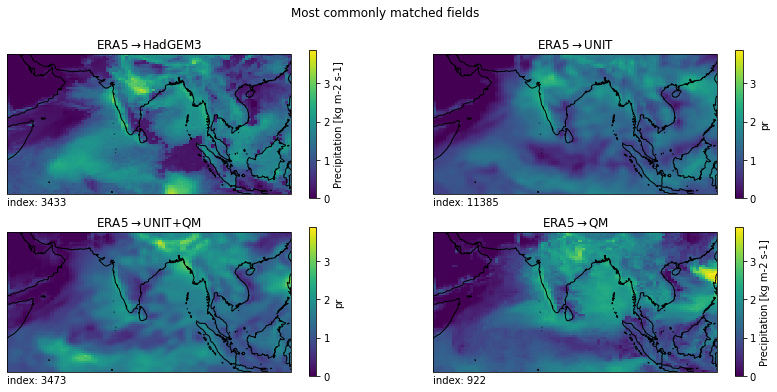

In [194]:
func = 'SSIM'
variable='pr'


plot_most_matched(era_match_modes, func, variable)

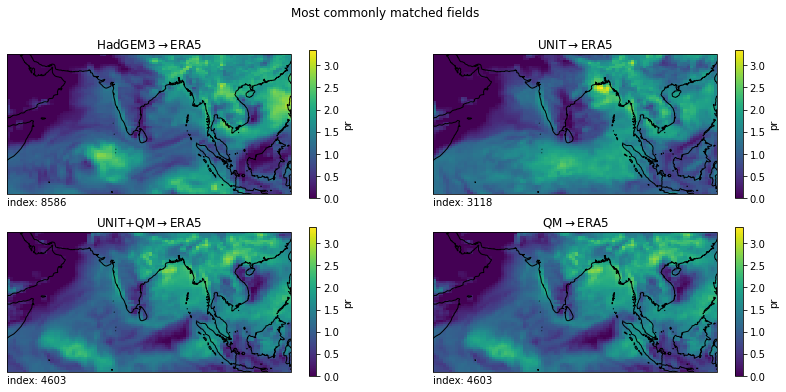

In [195]:
plot_most_matched(other_match_modes.T, func, variable)

# Translation of unrealistic HadGEM3 fields

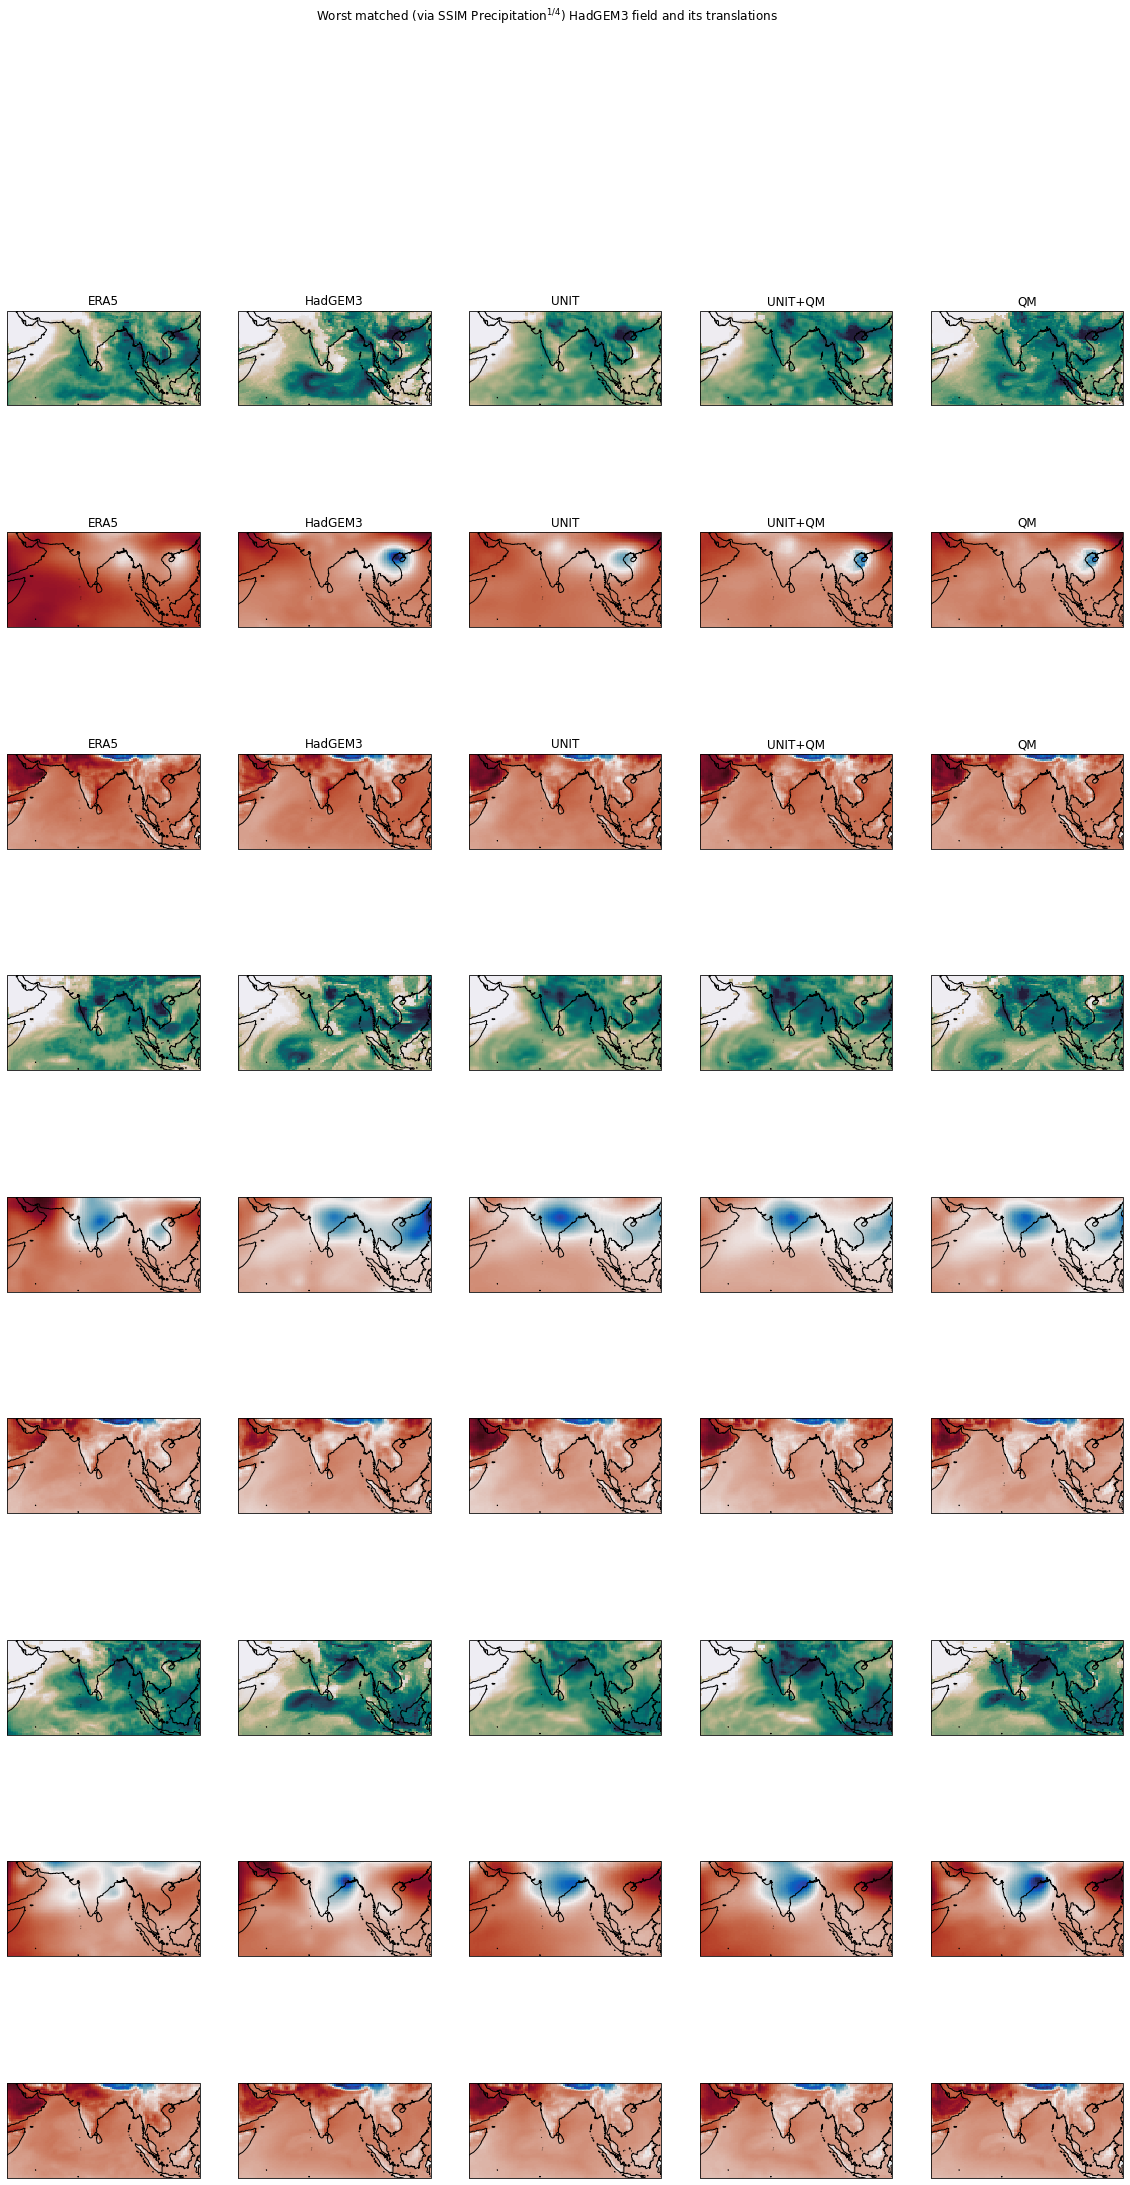

In [291]:
func_name = 'SSIM'
variable = 'Precipitation$^{1/4}$'
plot_transforms = lambda ds: [clip(ds.pr, None, 75)**0.25, ds.z500, ds.tas]
cmaps = cmocean.cm.rain, cmocean.cm.balance, cmocean.cm.balance
m = 3
s = 35
ns = np.arange(s, s+5)

ns = [11, 20, 30,]

worst_match_df = (
    other_match_ds.isel(match_to=0, drop=True)
        .sel(sample_from='HadGEM3', variable=variable, match_func=func_name, drop=True)
        .to_dataframe()
        .nlargest(max(ns)+1, 'values')
        .positions
        .astype(int)
)

worst_matched_indices = worst_match_df.index
worst_matches = worst_match_df.values

fig, axes = plt.subplots(len(ns)*m, len(all_ds), figsize=(20,12*m), sharex=True, sharey=True,
                         subplot_kw=dict(projection=projection))

def plot_axes(ax, ds, vmin, vmax, cmap, title):
    ds.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
    ax.set_title(ds.attrs['title'] if title else '')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.coastlines()
    trim_plot(ds, ax)


for idx, i in enumerate(ns):
    row_ds = [ds.isel(time=worst_matched_indices[i]) for ds in [ds_base, ds_trans, ds_transqm, ds_qm]]
    row_ds = [ds_target.isel(time=worst_matches[i])]+row_ds
    row_ds = [plot_transforms(ds) for ds in row_ds]
    vminmaxes = [common_min_max([ds[h] for ds in row_ds]) for h in range(m)]
    for j, ds in enumerate(row_ds):
        for k, (ds_i, cmap, (vmin, vmax)) in enumerate(zip(ds, cmaps, vminmaxes)):
            plot_axes(axes[idx*m+k, j], ds_i, vmin, vmax, cmap, title=idx==0)
            

plt.suptitle(f"Worst matched (via {func_name} {variable}) HadGEM3 field and its translations")
plt.show()

In [209]:
func_name = 'SSIM'
variable = 'Precipitation$^{1/4}$'
plot_transforms = lambda ds: [clip(ds.pr, 1e-2, 75)**0.25, ds.z500, ds.tas-273]
cmaps = cmocean.cm.rain, cmocean.cm.balance, cmocean.cm.balance
m = 3
s = 35
ns = np.arange(s, s+5)

ns = [11, 20, 30,]

worst_match_df = (
    other_match_ds.isel(match_to=0, drop=True)
        .sel(sample_from='HadGEM3', variable=variable, match_func=func_name, drop=True)
        .to_dataframe()
        .nlargest(max(ns)+1, 'values')
        .positions
        .astype(int)
)

worst_matched_indices = worst_match_df.index
worst_matches = worst_match_df.values

In [258]:
climateologies = [ds.groupby('time.month').mean(dim='time') 
                  for ds in all_ds]

In [293]:
def common_min_max_eq(ds_list):
    vmin, vmax = common_min_max(ds_list)
    if vmin<0 and vmax>0:
        vabs = np.abs([vmin, vmax]).max()
        vmin = -vabs
        vmax = vabs
    return vmin, vmax

In [298]:
plot_transforms = lambda ds, clim: [clip(ds.pr, 1e-2, 75)**0.25, ds.z500-clim.z500, ds.tas-clim.tas]
units = {
    'tas': r'$\Delta$°C',
    'pr': r'mm/day',
    'z500': '$\Delta$ metres',
}

long_name = {
    'tas': 'Temp.\nanomaly',
    'pr': 'Precip.',
    'z500': 'Geopot.\nanomaly',
}

plot_results = []
for idx, i in enumerate(ns):
    row_ds = []
    for ds, clim in zip(all_ds[1:], climateologies[1:]):
        climpart = ds.time.dt.month.isel(time=worst_matched_indices[i]).item()
        
        ds = ds.isel(time=worst_matched_indices[i]).compute()
        clim = clim.sel(month=climpart)
        
        row_ds += [plot_transforms(ds, clim)]
        
        
        
    
    # row_ds = [ds_target.isel(time=worst_matches[i]).compute()]+row_ds
    #row_ds = [plot_transforms(ds) for ds in row_ds]
    vminmaxes = [common_min_max([ds[h] for ds in row_ds]) for h in range(m)]
    plot_results += [(row_ds, vminmaxes)]

## Paper figure

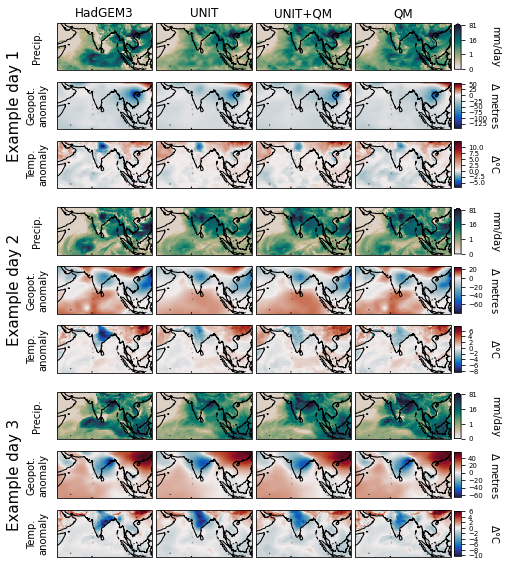

In [399]:
DPI=128
figsize = (8, 10)

this_cmaps =[cmocean.cm.rain]+[cmocean.cm.balance]*2


#fig, axes = plt.subplots(len(ns)*m, len(all_ds)-1, figsize=figsize, sharex=True, sharey=True,
#                         subplot_kw=dict(projection=projection))


fig = plt.figure(figsize=figsize)#, constrained_layout=True)
gs = fig.add_gridspec(11, 6, 
        height_ratios=[10]*3 + [1] + [10]*3 + [1] +[10]*3,
        width_ratios=[4]+[10]*4+[.7],
)

row_ns = [0,1,2, 4,5,6, 8,9,10]

axes = [[fig.add_subplot(gs[i, j], projection=projection) for j in range(1, 5)] for i in row_ns]

caxes = [fig.add_subplot(gs[i, -1].subgridspec(3, 1, height_ratios=[1,10,1])[1,0]) for i in row_ns]

laxes = [fig.add_subplot(gs[i:i+3, 0]) for i in row_ns[::3]]


def plot_axes(ax, ds, vmin, vmax, cmap, title=False, cax=None, 
              is_precip=False, xlabel=None, cbar_label=None, norm=None):
    pcm = ds.plot(ax=ax, vmin=vmin if not is_precip else 0, vmax=vmax, 
                  cmap=cmap, add_colorbar=False, norm=norm)
    ax.set_title(ds.attrs['title'] if title else '')
    ax.set_ylabel(None)
    ax.coastlines()
    if cax is not None:
        if is_precip:
            ticks=np.array([0,1,2,3]).astype(int)
            cbar = fig.colorbar(pcm, cax=cax, ticks=ticks, extend='max')
            cbar.set_ticklabels([t**4 for t in cbar.ax.get_yticks()])

        else:
            cbar = fig.colorbar(pcm, cax=cax)
            
        cbar.ax.tick_params(labelsize='x-small')
        cbar.ax.get_yaxis().labelpad = 15
        #cbar.ax.set_ylabel(cbar_label, rotation=270)
        cax.annotate(cbar_label, xy=(6, .5), xycoords='axes fraction', 
                    ha='center', va='center', rotation=270)
        
    #ax.set_xlabel(xlabel)
    ax.annotate(xlabel, xy=(-.2, .5), xycoords='axes fraction', ha='center', va='center', rotation=90)


for idx, i in enumerate(ns):
    row_ds, vminmaxes = plot_results[idx]
    #vminmaxes = vminmaxes[:-1]+[(290, vminmaxes[-1][-1])]
    for j, ds in enumerate(row_ds):
        for k, (ds_i, cmap, (vmin, vmax)) in enumerate(zip(ds, this_cmaps, vminmaxes)):
            if vmin<0 and vmax>0:
                norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            else:
                norm = None
            ax = axes[idx*m+k][j]
            plot_axes(ax, ds_i, vmin, vmax, cmap, 
                      title=(idx==0)&(k==0), 
                      cax=caxes[idx*m+k] if j==3 else None,
                      is_precip=k==0,
                      xlabel=long_name[ds_i.name] if j==0 else None,
                      cbar_label=units[ds_i.name],
                      norm=norm,
                     )
            trim_plot(ds_i, ax)
            

for l in range(3):
    laxes[l].axis('off')
    laxes[l].annotate(f'Example day {l+1}', xy=(0, .5), xycoords='axes fraction', 
                ha='center', va='center', rotation=90, fontsize=15)

#plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig('example_days.png', dpi=DPI)
plt.show()

# What does the monsoon look like?

> Following Hsu et al.[2011], the NHSM region encloses grid boxes for which the mean annual range (difference between the May–September and November–March averages) in precipitation for all years exceeds 2 mm d$^{−1}$ and the mean May–September precipitation exceeds 55% of the annual total. Grid boxes are excluded if they are north of the subtropics (40◦N) or isolated. The region is fixed for all years; therefore, any spatial shift of the monsoon is not captured. However, changes in precipitation due to possible variations inthe monsoon area should be small compared to the total precipitation in the whole region. Figure 2 shows that the NHSM region does not change by much over the observation period, with only a few grid boxes that meet the criteria in at least 1 year excluded from the final NHSM mask. An alternative method would allow the region to change year by year, but this could result in the region changing size, making it difficult to distinguish changes in precipitation rate from changes due to the NHSM region shrinking or growing overtime. The NHSM region is defined for each observational data set, and the model data are masked to match the spatial and temporal coverage of each
> 
> -- https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2014GL060811


In [281]:
# get mask from era5 dataset
for da in [all_ds[0].pr]:
    da = da.where(get_land_mask(da).astype(bool)).where(da.lat<=40)
    may_sept_pr = select_months(da.isel(run=0).clip(0,None), [5,6,7,8,9], drop=True).mean(dim='time')
    nov_mar_pr = select_months(da.isel(run=0).clip(0,None), [11,12,1,2,3], drop=True).mean(dim='time')
    yearly_pr = da.isel(run=0).clip(0,None).groupby(da.time.dt.year).sum(dim='time').mean(dim='year')
    monsoon_season_pr = select_months(da.isel(run=0).clip(0,None), [5,6,7,8,9], drop=True)
    monsoon_season_pr = (
        monsoon_season_pr.groupby(monsoon_season_pr.time.dt.year)
        .sum(dim='time')
        .mean(dim='year')
    )
    pr_diff_2 = (may_sept_pr - nov_mar_pr)>2
    pr_055 = monsoon_season_pr > 0.55*yearly_pr
    is_monsoon_gridpoint = xr.ufuncs.logical_and(
        pr_055,
        pr_diff_2
    )

/tmp/ipykernel_371889/20480137.py:15: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  is_monsoon_gridpoint = xr.ufuncs.logical_and(
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/dataarray.py:3081: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/variable.py:2409: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


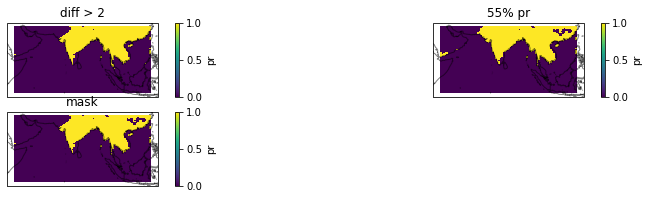

In [13]:

land_mask = True

plt.figure(figsize=(14,3))
for da, title, ax in zip(
    [pr_diff_2, pr_055, is_monsoon_gridpoint],
    ['diff > 2', '55% pr', 'mask'],
    [plt.subplot(221+i, projection=ccrs.PlateCarree()) for i in range(3)]
):
    da.plot(ax=ax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()


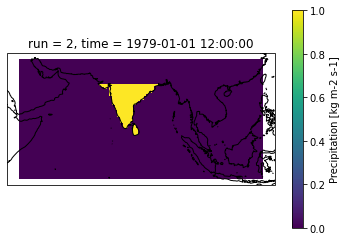

In [88]:
def get_land(ds):
    return ds.where(get_land_mask(ds)[0]).where((ds.lon>68)&(ds.lon<90)&(ds.lat<22))

ax = plt.subplot(111, projection=projection)
india_mask = get_land(ds_base['pr'].isel(time=0, run=0)).clip(1,1).fillna(0)
india_mask.plot(ax=ax)
ax.coastlines()
plt.show()

In [50]:
mask = is_monsoon_gridpoint # india_mask # 

monsoons = []
for ds in all_ds:
    
    precip_mean = select_months(
        ds.pr.where(mask).isel(run=0).clip(0,None), 
        np.arange(6,10),#[6, 7, 8, 9], 
        drop=True
    ).mean(dim=('lat', 'lon')).compute()
    high_precip = np.quantile(precip_mean, 0.9)
    precip_mask = precip_mean>high_precip
    
    monsoon = ds.isel(run=0).clip(0,None).where(precip_mask).mean(dim=('time')).compute()
    monsoons.append(monsoon)

monsoons = xr.concat([m.assign_coords(datasource=[m.attrs['title']]) for m in monsoons], dim='datasource')
monsoons['tas'] = monsoons.tas - 273

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/xarray/core/indexes.py:250: RuntimeWarning: cannot compare cftime.Datetime360Day(2013, 9, 30, 12, 0, 0, 0, has_year_zero=True) and Timestamp('2013-08-26 00:00:00') (different calendars), sort order is undefined for incomparable objects
  new_index = self.index.union(other.index)


In [132]:
monsoons = []
for ds, bs in zip(all_ds, basin_accumulated_pr):
    ref_quantity = bs.sel(basin='Ganges-Brahmaputra')
    threshold = np.quantile(ref_quantity, 0.8)
    precip_mask = ref_quantity>threshold
    monsoon = ds.isel(run=0).clip(0,None).where(precip_mask).mean(dim=('time')).compute()
    monsoons.append(monsoon)
monsoons = xr.concat([m.assign_coords(datasource=[m.attrs['title']]) for m in monsoons], dim='datasource')
monsoons['tas'] = monsoons.tas - 273

In [41]:
var_cmaps = {'pr':cmocean.cm.rain, 'tas':cmocean.cm.balance, 'z500':cmocean.cm.balance}
long_name = {
    'tas': r'Temp.',
    'pr': r'Precip.',
    'z500': 'Geopot.',
}

def plot_absolute(monsoon, axes, title='', vmins=None, vmaxes=None, add_var_names=False, add_colorbar=False):
    for i, var in enumerate(['pr', 'tas', 'z500']):
        if vmins is not None:
            vmin = vmins[var]
            vmax = vmaxs[var]
        else:
            vmin = vmax = None
        pcm = monsoon[var].plot(ax=axes[i], vmin=vmin, vmax=vmax, cmap=var_cmaps[var], add_colorbar=False)
        if add_var_names:
            axes[i].annotate(long_name[var], xy=(-.1, .5), 
                             xycoords='axes fraction', 
                             ha='center', va='center', rotation=90
            )
        if add_colorbar:
            extend = 'max' if var=='pr' else 'both'
            fig.colorbar(pcm, ax=axes[i], location='right', shrink=.95, aspect=10, extend=extend)
    for ax in axes:
        trim_plot(monsoon, ax)
        ax.coastlines()
    axes[0].set_title(title)
    for ax in axes[1:]: ax.set_title('')
    
    return pcm

def plot_relative(monsoon, axes, title='', vmins=None, vmaxes=None):
    for i, var in enumerate(['pr', 'tas', 'z500']):
        if vmins is not None:
            vabs = min(-vmins[var], vmaxs[var])
            vmin = -vabs
            vmax = vabs
        else:
            vmin = vmax = None
        monsoon[var].plot(ax=axes[i], vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, 
                          norm=colors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=0.))
    for ax in axes:
        trim_plot(monsoon, ax)
        ax.coastlines() 
    #axs[0].annotate(title, xy=(-.2, .5), xycoords='axes fraction', ha='center', va='center', rotation=90)
    axes[0].set_title(title)
    for ax in axes[1:]: ax.set_title('')

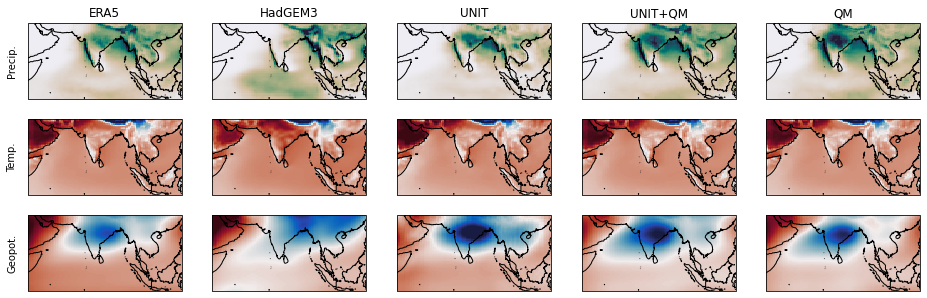

In [44]:
fig, axes = plt.subplots(3,len(all_ds), figsize=(16,5), subplot_kw=dict(projection=projection))
diff_monsoons = monsoons.sel(datasource=slice('HadGEM3', None)) - monsoons.sel(datasource='ERA5')

relative=0
#vmins = diff_monsoons.min(dim=('datasource', 'lat', 'lon'))
#vmaxs = diff_monsoons.max(dim=('datasource', 'lat', 'lon'))

if relative:
    vmins = diff_monsoons.quantile(0.00)
    vmaxs = diff_monsoons.quantile(1.)
else:
    vmins = monsoons.quantile(0.005)
    vmaxs = monsoons.quantile(0.995)   

for i, (datasource, axs) in enumerate(zip(diff_monsoons.datasource.values, axes.T[1:])):
    
    m = diff_monsoons if relative else monsoons
    monsoon = m.sel(datasource=datasource)
    title = f"{datasource} - ERA5" if relative else datasource
    last = i==len(all_ds)-2
    if relative:
        plot_relative(monsoon, axs, title=title, vmins=vmins, vmaxes=vmaxs)
    else:
        plot_absolute(monsoon, axs, title=title, vmins=vmins, vmaxes=vmaxs, add_colorbar=False)

if relative:
    vmins = vmaxes = None
    
plot_absolute(monsoons.sel(datasource='ERA5'), axes.T[0], title='ERA5', 
              vmins=vmins, vmaxes=vmaxs, add_var_names=True
)
plt.savefig("figs/high_precip_monsoon-no_bar.png", dpi=128)

# Basins

In [20]:
#all_basin_masks = xr.load_dataset('~/netcdf_store/Major_Basins_of_the_World/Major_Basins_of_the_World.nc')
all_basin_masks = (
    xr.load_dataset('/home/s1205782/netcdf_store/all_world_all_basin_masks_hadgem3.nc')
    .groupby('basin').any(dim='basin')
)
#all_basin_masks = all_basin_masks.where(all_basin_masks.sum(dim=('lat', 'lon'))>0, drop=True) 

## Ganges basin 1D precip dists

In [21]:
basin_mask = (
    all_basin_masks.where(
            all_basin_masks.basin.str.startswith('Gang'), 
        drop=True
    ).sum(dim='basin')
)

In [ ]:
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=projection), figsize=(16,3.5))
basin_mask.mask.plot(cmap='Blues')
ax.coastlines()
plt.show()

In [ ]:
for ds in all_ds:
    if ds.attrs['title']=='ERA5':
        histtype='stepfilled'
        alpha=.5
    else:
        histtype='step'
        alpha=1
    histtype, alpha = ('stepfilled', 0.5) if ds.attrs['title']=='ERA5' else ('step', 1)
    ds = ds.isel(run=0)
    ds = ds.where(basin_mask.mask).pr.mean(dim=('lat', 'lon'))
    ds.plot.hist(bins=100, label=ds.attrs['title'], 
                 histtype=histtype, alpha=alpha, log=True)
#plt.yscale('log')
plt.xlabel("Precipitation (mm day$^{-1}$)")
plt.legend()
plt.show()

In [ ]:
dm.where(dm>np.quantile(dm.values, 0.9), drop=True).time

In [ ]:
def plot_extreme_basin_mean(basin_mask):
    fig, axes = plt.subplots(3,2)
    for ax, ds in zip(axes.flatten()[[0,2,3,4,5]], all_ds):
        if ds.attrs['title']=='ERA5':
            histtype='stepfilled'
            alpha=.5
        else:
            histtype='step'
            alpha=1
        histtype, alpha = ('stepfilled', 0.5) if ds.attrs['title']=='ERA5' else ('step', 1)
        ds = ds.isel(run=0).where(basin_mask)
        dm = ds.pr.mean(dim=('lat', 'lon'))

        (
            ds.sel(time=dm.where(dm>np.quantile(dm.values, 0.9), drop=True).time)
            .pr.mean(dim='time')
            .where(basin_mask, drop=True)
        ).plot(ax=ax, vmin=0, vmax=50, add_colorbar=False)
        ax.set_title(ds.attrs['title'])
        ax.set_xlabel('')
        ax.set_ylabel('')
    axes[0,1].axis('off')
    #plt.tight_layout()
    plt.show()

In [ ]:
plot_extreme_basin_mean(basin_mask.mask)

## Other basins

In [ ]:
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=projection), figsize=(19,3.5))


basin_ints = xr.DataArray(np.arange(1, len(all_basin_masks.basin)+1), 
                          coords=[all_basin_masks.basin], dims=['basin'])
basin_contour = (all_basin_masks.mask*basin_ints).sum(dim='basin')
basin_contour = basin_contour.where(basin_contour>0)
cmap  = 'gist_rainbow'#cm.get_cmap('gist_rainbow', len(all_basin_masks.basin)-1)
c = basin_contour.plot(cmap=cmap, add_colorbar=True,linewidths=0, 
                       cbar_kwargs={'orientation':'horizontal',},)

cbar = c.colorbar
cbar.ax.tick_params(rotation=90)
cbar.set_ticks(np.arange(1, len(all_basin_masks.basin)+1))
cbar.set_ticklabels(all_basin_masks.basin.values)

for basin in all_basin_masks.basin.values:
    basin_mask  = all_basin_masks.sel(basin=basin)
    basin_mask.mask.plot.contour(colors='k', add_colorbar=False,
            linewidths=1, levels=np.arange(1, len(all_basin_masks.basin)+2)-0.5, )
ax.coastlines()
plt.show()

## Paper basin msk plot

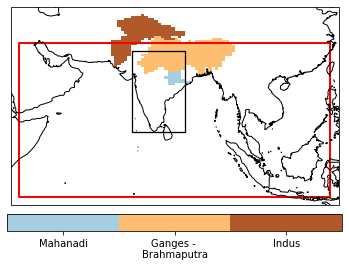

In [120]:

from shapely import geometry
from shapely.geometry import Polygon

N = 30
S = -8
E = 121
W = 44

def plot_slected_basins(selected_basins, cmap_name='gist_rainbow', show_complete_basins=False):

    fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=projection), figsize=(6,4.5))

    basin_ints = xr.DataArray(np.arange(1, len(selected_basins)+1), 
                              coords=[selected_basins], dims=['basin'])
    basin_contour = (all_basin_masks.sel(basin=selected_basins).mask*basin_ints).sum(dim='basin')
    basin_contour = basin_contour.where(basin_contour>0)
    
    cmap = plt.get_cmap(cmap_name, len(selected_basins))
    cmap_bounds = np.arange(1, len(selected_basins)+2) - 0.5
    norm = colors.BoundaryNorm(cmap_bounds, cmap.N)


    for i, basin in enumerate(selected_basins):
        basin_mask  = all_basin_masks.sel(basin=basin)
        if i==0:
            cbar = basin_contour.plot(
                cmap=cmap, norm=norm, add_colorbar=True, linewidths=2, 
                cbar_kwargs={'orientation':'horizontal', 'pad':0.04,},
            ).colorbar
        else:
            basin_contour.plot(
                cmap=cmap, norm=norm, add_colorbar=False, linewidths=20,
            )
    
    cbar.ax.tick_params(rotation=0)
    cbar.set_ticks(np.arange(1, len(selected_basins)+1))
    labels = [s.replace('-', ' - \n') for s in selected_basins]
    cbar.set_ticklabels(labels)
    
    ax.coastlines(zorder=2)
    plt.title('')
    
    if show_complete_basins:
        geom = Polygon([[W, S], [E, S], [E, N], [W, N], [W, S]])
        ax.add_geometries([geom], crs=projection, linewidth=2, facecolor="None", edgecolor='red', zorder=1)
        
        these_basins = all_basin_masks.sel(basin=selected_basins).any(dim='basin')
        ew_extent = these_basins.where(these_basins.any(dim='lat'), drop=True).lon
        ns_extent = these_basins.where(these_basins.any(dim='lon'), drop=True).lat
        b = 2
        w = min(W, ew_extent.min())-b
        e = max(E, ew_extent.max())+b
        n = max(N, ns_extent.max())+b
        s = min(S, ns_extent.min())-b
        ax.set_extent([w, e, s, n], crs=projection)
    else:
        ax.set_extent([W, E, S, N], crs=projection)
    return fig, ax

fig, ax = plot_slected_basins(['Mahanadi', 'Ganges-Brahmaputra', 'Indus'], 'Paired', True)

N = 28
S = 8
E = 85
W = 72

geom = Polygon([[W, S], [E, S], [E, N], [W, N], [W, S]])
ax.add_geometries([geom], crs=projection, linewidth=1.3, alpha=1, facecolor="None", edgecolor='k', zorder=1)
#
plt.savefig("figs/basins_masks2.png", dpi=300)
plt.show()

In [26]:
selected_basins = ['Godavari', 'Krishna', 'Cauvery', 'Indus',
                   'Irrawaddy', 'Mahanadi', 'Mekong', 'Ganges-Brahmaputra', 'Tapti', 'Narmada']

all_basin_masks = all_basin_masks.sel(basin=selected_basins)

In [ ]:
for basin in selected_basins:
    
    basin_mask = all_basin_masks.sel(basin=basin).mask
    
    fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=projection), figsize=(16,3.5))
    basin_mask.plot(cmap='Blues', ax=ax, add_colorbar=False,)
    ax.coastlines()
    
    fig, ax = plt.subplots(1,1)
    
    basin_precip = [ds.where(basin_mask).pr.mean(dim=('lat', 'lon')).isel(run=0) for ds in all_ds]
    vmin, vmax  = common_min_max(basin_precip)
    for ds in basin_precip:
        if ds.attrs['title']=='ERA5':
            histtype='stepfilled'
            alpha=.5
        else:
            histtype='step'
            alpha=1
        histtype, alpha = ('stepfilled', 0.5) if ds.attrs['title']=='ERA5' else ('step', 1)
        ds.plot.hist(range=(vmin, vmax), bins=100, label=ds.attrs['title'], 
                     histtype=histtype, alpha=alpha, ax=ax)
    plt.yscale('log')
    plt.xlabel("Precipitation (mm day$^{-1}$)")
    plt.legend()
    plt.show()
    
    plot_extreme_basin_mean(basin_mask)

## Joint plot of precip in multiple basins

In [27]:
basin_accumulated_pr = [
    ds.pr.where(all_basin_masks.mask)
        .mean(dim=('lat', 'lon'))
        .isel(run=0) 
    for ds in all_ds
]

In [28]:
def basin_precip_joint_plot(two_basins):

    def transform(ds):
        x = (clip(ds.sel(basin=two_basins[0]), 1e-5, None))**.25
        y = (clip(ds.sel(basin=two_basins[1]), 1e-5, None))**.25
        return x, y

    xs = [transform(ds) for ds in basin_accumulated_pr]
    s=1.3
    fig, axes = plt.subplots(3,2, figsize=(6*s,8*s), sharex=True, sharey=True)

    def _plot(x, ax):
        ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
        #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
        ax.annotate(x[1].attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
        sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        rect1 = matplotlib.patches.Rectangle((-1,0), 1, 100, color='white',zorder=2)
        ax.add_patch(rect1)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)

    for x, ax in zip(xs, axes.flatten()[[0,2,3,4,5]]):
        _plot(x, ax)
        pr_axis(ax, labels=np.array([0,1,16,81]), ylabels=np.array([0,1,16,81]), both=True)

    for ax in axes[-1,:]:
        ax.set_xlabel(two_basins[0])
    for ax in axes[:,0]:
        ax.set_ylabel(two_basins[1])
    
    axes[0, -1].axis('off')
    return fig

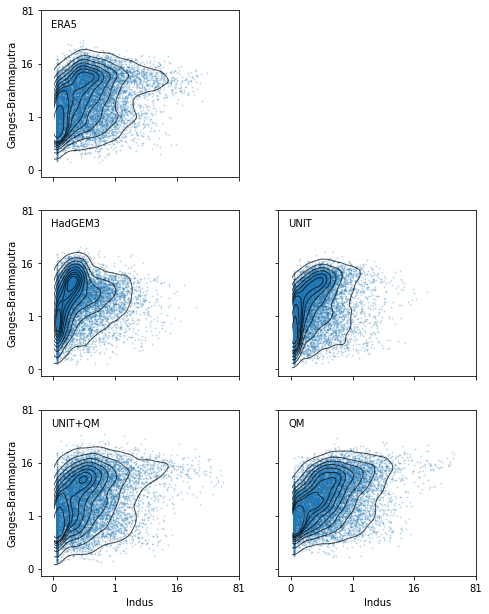

In [29]:
two_basins = ['Indus', 'Ganges-Brahmaputra']
basin_precip_joint_plot(two_basins)
#plt.savefig("figs/2basins_pr_joint.png", dpi=300)
plt.show()

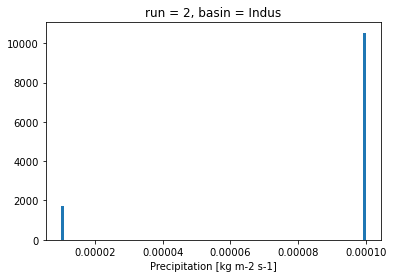

In [83]:
xs[-1][0].clip(None, 0.0001).plot.hist(bins = 100);

In [85]:
[x[:3] for x in np.unique(xs[0][0].clip(None, 0.0001), return_counts=True)]

[array([9.9999997e-06, 1.0038712e-05, 1.0090362e-05], dtype=float32),
 array([2406,    1,    1])]

In [91]:
[x[:3] for x in np.unique(xs[2][0].clip(None, 0.0001), return_counts=True)]

[array([1.00000000e-05, 1.00421510e-05, 1.00448969e-05]),
 array([4297,    1,    1])]

<Figure size 432x288 with 0 Axes>

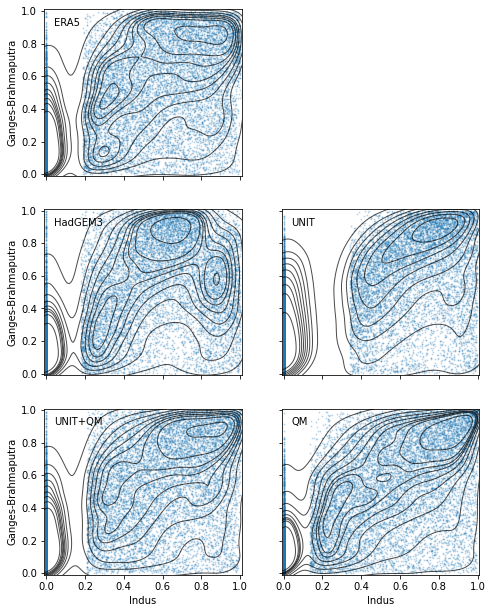

In [61]:
def _transform(ds):
    x = clip(ds.sel(basin=two_basins[0]), 1e-5, None)
    y = clip(ds.sel(basin=two_basins[1]), 1e-5, None)
    return x, y

xs = [_transform(ds) for ds in basin_accumulated_pr]
    
plot_vrac(xs, xlabel=two_basins[0], ylabel=two_basins[1], d=0.01)
plt.savefig("figs/2basins_pr_joint_vrac.png", dpi=300)
plt.show()

In [ ]:
two_basins = ['Cauvery', 'Godavari']
basin_precip_joint_plot(two_basins)

## Get JS div for plot above

In [ ]:
import cupy as cp
from cupy.cuda import Device
from kl_div_map import est_js_div

In [ ]:
def transform(da):
    return da**.25

In [ ]:
[x.attrs['title'] for x in basin_accumulated_pr]

In [ ]:
# create array to store results
titles = [x.attrs['title'] for x in basin_accumulated_pr[1:]]
basins = basin_accumulated_pr[0].basin.values
bins_list = [5, 10, 15, 20, 30, 40, 50, 100]
gpu_device = 2

basin_js = xr.DataArray(
    np.zeros(
        (
            len(basins), 
            len(basins), 
            len(titles), 
            len(bins_list)
        ),
    ),
    coords=[
        basins,
        basins,
        titles,
        bins_list,
    ],
    dims=['basin_a', 'basin_b', 'dataset', 'bins'],
    name='js_div'
)

for i, basin_a in tqdm(enumerate(basins)):
    for j, basin_b in enumerate(basins):
        ref_values = (
            transform(basin_accumulated_pr[0].sel(basin=basin_a)),
            transform(basin_accumulated_pr[0].sel(basin=basin_b))
        )
            
        for k, x in enumerate(basin_accumulated_pr[1:]):
            test_values = (
                transform(x.sel(basin=basin_a)),
                transform(x.sel(basin=basin_b))
            )
            dataset = x.attrs['title']
            for m, bins in enumerate(bins_list):
                with Device(gpu_device):
                    js = est_js_div(test_values, ref_values, bins=bins)
                basin_js[i,j,k,m] = js
                assert basin_js.sel(basin_a=basin_a, basin_b=basin_b, dataset=dataset, bins=bins)==js

In [ ]:
basin_js.to_netcdf("~/netcdf_store/basin_js.nc")
#basin_js = xr.load_dataset("~/netcdf_store/basin_js.nc")

In [ ]:
for dataset in basin_js.dataset.values:
    (
        basin_js.sel(dataset=dataset, basin_a=selected_basins, basin_b=selected_basins)
        .mean(dim=('basin_a', 'basin_b'))
    ).js_div.plot(label=dataset)

plt.legend()
plt.title('')
plt.ylabel('JS-divergence')
plt.show()

**Which basins had the best joint distribution match to ERA5 and which dataset was this from?**

In [ ]:
basin_kl

In [ ]:
for bins in basin_kl.bins.values:
    x = basin_kl.js_div.sel(basin_a=selected_basins, basin_b=selected_basins, bins=bins)
    x = x.where(x.basin_a!=x.basin_b)
    x = x.where(x==x.min(), drop=True)
    if x.basin_a.shape[0]>1:
        x = x.isel(basin_a=[0], basin_b=[1])
    print(
        f"bins={bins} : {np.nanmin(x.values):.4f} - {x.dataset.values[0]}" +
        f" - ['{x.basin_a.values[0]}', '{x.basin_b.values[0]}']"
    )

In [ ]:
these_basins = ['Indus', 'Irrawaddy']
plot_slected_basins(these_basins)
basin_precip_joint_plot(these_basins)

In [ ]:
these_basins = ['Krishna', 'Godavari']
plot_slected_basins(these_basins)
basin_precip_joint_plot(these_basins)

In [ ]:
these_basins = ['Irrawaddy', 'Ganges-Brahmaputra']
plot_slected_basins(these_basins)
basin_precip_joint_plot(these_basins)

In [ ]:
basin_pairs = [
    ['Godavari', 'Mahanadi'], ['Cauvery', 'Krishna'], 
   ['Indus', 'Ganges-Brahmaputra'], 
   ['Godavari', 'Ganges-Brahmaputra']
]

for these_basins in basin_pairs:
    plot_slected_basins(these_basins)
    basin_precip_joint_plot(these_basins)

In [ ]:
basin_pairs = [['Tapti', 'Narmada']]for these_basins in  basin_pairs:
    plot_slected_basins(these_basins)
    basin_precip_joint_plot(these_basins)

In [ ]:
basin_pairs = [
    ['Tapti', 'Krishna'], 
    ['Narmada', 'Krishna'], 
    ['Narmada', 'Ganges-Brahmaputra'], 
    ['Tapti', 'Ganges-Brahmaputra']
]

for these_basins in basin_pairs:
    plot_slected_basins(these_basins)
    basin_precip_joint_plot(these_basins)

## Single basin precip and temp joint plots

In [ ]:
basin_accumulated = [ds.where(all_basin_masks.mask).mean(dim=('lat', 'lon')).isel(run=0) for ds in all_ds]

In [39]:
def basin_prtas_transform(ds):
    x = (clip(ds.pr, 1e-5, None))**.25
    y = ds.tas-273
    return x, y

def basin_prz500_transform(ds):
    x = (clip(ds.pr, 1e-5, None))**.25
    y = ds.z500
    return x, y

def basin_tasz500_transform(ds):
    x = ds.tas
    y = ds.z500
    return x, y


def basin_precip_temp_plot(basin):
    xs = [basin_prtas_transform(ds.sel(basin=basin)) for ds in basin_accumulated]

    s=1.3
    fig, axes = plt.subplots(3,2, figsize=(6*s,8*s), sharex=True, sharey=True)

    def _plot(x, ax):
        ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
        #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
        ax.annotate(x[1].attrs['title'], xy=(0.9, 0.9), xycoords='axes fraction', ha='right')
        sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        rect1 = matplotlib.patches.Rectangle((-1,0), 1, 100, color='white',zorder=2)
        ax.add_patch(rect1)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)

    for x, ax in zip(xs, axes.flatten()[[0,2,3,4,5]]):
        _plot(x, ax)

    for ax in axes[-1,:]:
        ax.set_xlabel('Mean basin precipitation (mm day$^{-1}$)')
        pr_axis(ax, labels=np.array([0,1,16,81]), both=False)
        
    for ax in axes[:,0]:
        ax.set_ylabel('Mean basin temperature (°C)')

    axes[0, -1].axis('off')

    return fig
    
def basin_precip_z500_plot(basin):
    xs = [basin_prz500_transform(ds.sel(basin=basin)) for ds in basin_accumulated]

    plt.figure()

    fig, axes = plt.subplots(2,3, figsize=(12,6), sharex=True, sharey=True)

    def _plot(x, ax):
        ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
        #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
        #ax.annotate(x[1].attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
        sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )

    for x, ax in zip(xs, axes.flatten()):
        _plot(x, ax)

    for ax in axes[-1,:]:
        ax.set_xlabel('Mean basin precip ^ 1/4')
    for ax in axes[:,0]:
        ax.set_ylabel('z500 geopotential height')
    plt.suptitle(f'{basin} basin')

    axes[-1, -1].axis('off')

    plt.show()
    
def basin_temp_z500_plot(basin):
    xs = [basin_tasz500_transform(ds.sel(basin=basin)) for ds in basin_accumulated]

    plt.figure()
    s=1.2
    fig, axes = plt.subplots(3,2, figsize=(12,6), sharex=True, sharey=True)

    def _plot(x, ax):
        ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
        #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
        #ax.annotate(x[1].attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
        sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )

    for x, ax in zip(xs, axes.flatten()):
        _plot(x, ax)

    for ax in axes[-1,:]:
        ax.set_xlabel('Mean basin temperature')
    for ax in axes[:,0]:
        ax.set_ylabel('z500 geopotential height')
    plt.suptitle(f'{basin} basin')

    axes[-1, -1].axis('off')
    

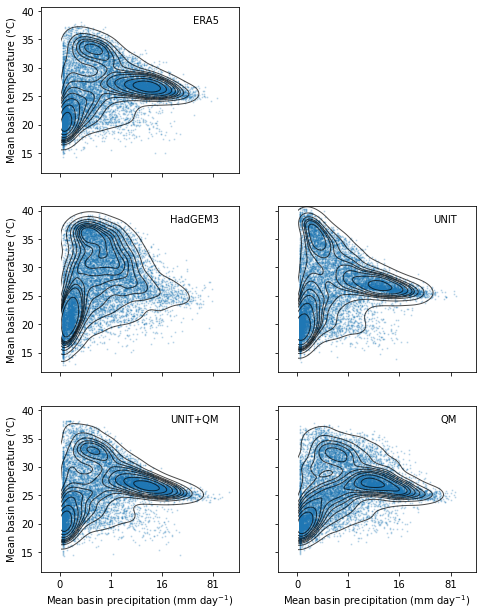

In [42]:
basin_precip_temp_plot('Mahanadi')
plt.savefig("figs/single_basin_joint2.png", dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

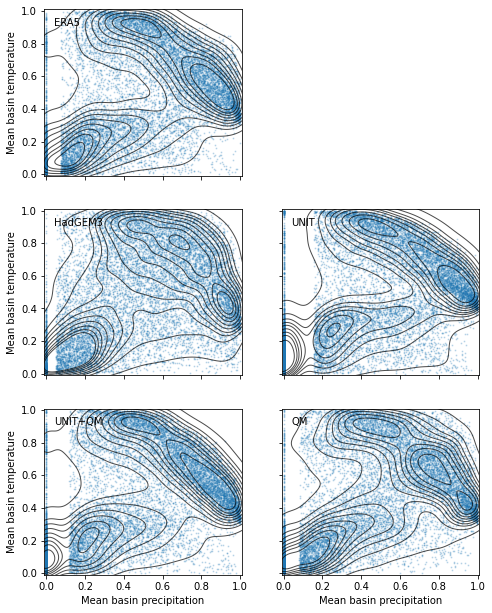

In [58]:
def _transform(ds):
    x = ds.pr
    y = ds.tas
    return x, y

xs = [basin_prtas_transform(ds.sel(basin='Mahanadi')) for ds in basin_accumulated]

plot_vrac(xs, xlabel=r'Mean basin precipitation', ylabel=r'Mean basin temperature', d=0.01)
plt.savefig("figs/single_basin_joint2_vrac.png", dpi=300)
plt.show()

In [ ]:
# create array to store results
titles = [x.attrs['title'] for x in basin_accumulated[1:]]
basins = basin_accumulated[0].basin.values
bins_list = [5, 10, 15, 20, 30, 40, 50, 100]
gpu_device = 2

basin_var_kl = xr.DataArray(
    np.zeros(
        (
            len(basins),
            len(titles), 
            len(bins_list)
        ),
    ),
    coords=[
        basins,
        titles,
        bins_list,
    ],
    dims=['basin', 'dataset', 'bins'],
    name='kl_div',
)

for i, basin in tqdm(enumerate(basins)):
    ref_values = basin_prtas_transform(basin_accumulated[0].sel(basin=basin))

    for j, x in enumerate(basin_accumulated[1:]):
        test_values = basin_prtas_transform(x.sel(basin=basin))
        dataset = x.attrs['title']
        for k, bins in enumerate(bins_list):
            with Device(gpu_device):
                kl = est_kl_div(test_values, ref_values, bins=bins)
            basin_var_kl[i,j,k] = kl
            assert basin_var_kl.sel(basin=basin, dataset=dataset, bins=bins)==kl

In [ ]:
basin_var_kl.to_netcdf("~/netcdf_store/basin_var_kl.nc")

In [ ]:
for dataset in basin_var_kl.dataset.values:
    basin_var_kl.sel(dataset=dataset, basin=selected_basins).mean(dim='basin',).plot(label=dataset)
plt.legend()
plt.title('')
plt.ylabel('KL-divergence')
plt.show()

In [ ]:
for bins in basin_var_kl.bins:
    x = basin_var_kl.sel(basin=selected_basins, bins=bins)
    x = x.where(x==x.min(), drop=True)
    print(f"bins={x.bins.values} : {x.values.item():.4f} - {x.dataset.values[0]} - {x.basin.values[0]}")

In [ ]:
basin_temp_z500_plot('Mahanadi')
basin_precip_temp_plot('Mahanadi')
basin_precip_z500_plot('Mahanadi')

# Radial power spectral density

Note to self, I tried this using spherical harmonic transform by fitting coefficients to the data in the monsoon region. In experiments where I constructed data with know spherical harmonic coefficients this didn't work. You have to fit the coefficicients using least squares, similar to fitting irregular spaced fourier transform. The fitting was better if I padded the data out with zeros to give a regular field, but still not ideal. Instead I'm going to go with the 2d fourier transform. 

```
import pyshtools as pysh
from scipy.special import sph_harm

# with real data
z = ds_target.z500.isel(run=0, time=0)

# with constructed data
z = sph_harm(2, 3, np.deg2rad(ds_target.lat), np.deg2rad(ds_taret.lon))

z = z.stack(z=("lat", "lon"))

sh = pysh.expand.SHExpandLSQ(z.values, z.lat.values, z.lat.lon, 10)[0]
plt.plot(pysh.spectralanalysis.spectrum(sh))
```

In the following blocks I define functions and test them with generated data

https://notebook.community/ioshchepkov/SHTOOLS/examples/notebooks/Introduction-2

In [ ]:
import seaborn as sns
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def gaussian(x, sigma):
    g = np.exp(-x**2/(2*sigma**2))
    return g

def gaussian_smooth(x, y, sigma):
    g = gaussian(x[None, :] - x[:, None] , sigma)
    g = g/g.sum(0, keepdims=True)
    return (g*y[:, None]).sum(axis=0)

def fourier_transform(da):
    lat = da.lat.values
    lon = da.lon.values
    
    fourier_coeffs = np.fft.fftn(da.values, axes=(1,2))

    k_lat = np.fft.fftfreq(len(lat), d=lat[1]-lat[0])
    k_lon = np.fft.fftfreq(len(lon), d=lon[1]-lon[0])
    
    fourier_coeffs = xr.DataArray(
        fourier_coeffs,
        coords=[
            da.time,
            k_lat,
            k_lon,
        ],
        dims=['time', 'k_lat', 'k_lon'],
    )
    return fourier_coeffs

def inverse_fourier_transform(da, lats, lons):
    
    values = np.fft.ifftn(da.values, axes=(1,2))
    
    values = xr.DataArray(
        values,
        coords=[
            da.time,
            lats,
            lons,
        ],
        dims=['time', 'lat', 'lon'],
    )
    return values

def power_spectral_density(da):
    fourier_amplitudes = np.abs(fourier_transform(da))**2

    psd = fourier_amplitudes \
        .mean(dim='time') \
        .groupby((fourier_amplitudes.k_lon**2 + fourier_amplitudes.k_lat**2)**0.5) \
        .mean() \
        .rename({'group':'k'})
    return psd

In [ ]:

# wavelength, angle, and amplitide to put into each image
wavelengths_lists = [
    [43,],
    [20,],
    [7,],
    [5,],
]
amplitudes_lists = [
    [2,],
    [2,], 
    [2,],
    [2,],
]
angles_lists = [
    [0,],
    [None,], 
    [20,],
    [-10,],
]

# copies of each image
copies=10

# coordinates of points
lat = np.linspace(-50, 50, 100, endpoint=False)
lon = np.linspace(-100, 120, 100, endpoint=False)
 

# begin construction
lons, lats = np.meshgrid(lon, lat)

rad = (lats**2 + lons**2)**0.5
ang = np.arctan(lats/lons)

base_images = []
for params in zip(amplitudes_lists, wavelengths_lists, angles_lists):
    image = 0
    for amp, wavelength, angle in zip(*params):
        if angle is None:
            image += amp*np.cos(2*np.pi*rad/wavelength)
        else:
            image += amp*np.cos(2*np.pi*rad*np.cos(angle-ang)/wavelength)
    base_images+=[image]

base_images = np.tile(np.array(base_images), (copies, 1,1))

images = base_images + np.random.normal(0,1, base_images.shape)
    
generated_images = xr.DataArray(
    images,
    coords=[
        np.arange(len(images)),
        lat,
        lon,
    ],
    dims=['time', 'lat', 'lon',],
)

In [ ]:
generated_images.isel(time=slice(0,len(wavelengths_lists))).plot(col='time')

In [ ]:
gen_ft = (np.abs(fourier_transform(generated_images))**2).sortby('k_lat').sortby('k_lon')
np.log(gen_ft.isel(time=slice(0,len(wavelengths_lists)))).plot(col='time', vmin=9)

In [ ]:
psd = power_spectral_density(generated_images)
s = gaussian_smooth(np.log(psd.k).values, psd.values, .02)

In [ ]:
# expected peaks
df = pd.DataFrame({
    'wavelengths':[wl for wlist in wavelengths_lists for wl in wlist],
    'amplitudes':[a for alist in amplitudes_lists for a in alist],
}).groupby('wavelengths').sum().rename({'amplitudes':'amplitudes sum'}, axis=1)
df['k'] = 1/df.index
df['k'] = df['k'].apply(lambda x: f"{x:.2E}")

In [ ]:
ax = plt.subplot()

plt.xscale('log')
plt.yscale('log')

for k in df.k.values:
    #continue
    plt.axvline(x=float(k), color='r')
psd.plot(color='grey', alpha=.9)
#plt.axhline(y=psd.mean(), color='r')
plt.plot(psd.k, s, color='k')
#plt.xlim(1.9e-1, 2.1e-1)
#plt.xlim(1.3e-1, 1.7e-1)

In [ ]:
df

In [ ]:
ds = ds_base.isel(run=0).load()

In [ ]:
ds = (ds.groupby(ds.time.dt.dayofyear) - ds.groupby(ds.time.dt.dayofyear).mean()).drop('dayofyear')

In [ ]:
da = ds['z500'].isel(time=slice(0, 100))

In [ ]:
psd = power_spectral_density(da)
s = gaussian_smooth(np.log(psd.k).values, psd.values, .02)

In [ ]:
psd

In [ ]:
ax = plt.subplot()

plt.xscale('log')
plt.yscale('log')
psd.plot(color='k', alpha=0.5)
#plt.axhline(y=psd.where(psd.k>0).mean(), color='r')
plt.plot(psd.k, s, color='k')

In [ ]:
ax = plt.subplot()

plt.xscale('log')
plt.yscale('log')

angles = ds.lat.values
for l in np.fft.fftfreq(len(angles), d=angles[1]-angles[0]):
    plt.axvline(x=l, color='r')
plt.plot(psd.k, s, color='k')
psd.plot(color='k', alpha=0.5)
#plt.xlim(0.1, 0.15)

In [ ]:
da_ft = fourier_transform(da)

In [ ]:
inverse_fourier_transform(da_ft.where(da_ft.k_lon==0).fillna(0), ds.lat, ds.lon).isel(time=0).real.plot()

It seems no matter how I try to normalise the data, the N-S direction always dominates the power spectrum.

In [ ]:
rt = g.time*0+np.random.normal(0,10, g.time.shape)
g = generated_images
g = g + (g.lat/100)*rt # superimpose random N-S trend on top of images

In [ ]:
psd = power_spectral_density(g)

In [ ]:
ax = plt.subplot()

plt.xscale('log')
plt.yscale('log')

angles = g.lat.values
for l in np.fft.fftfreq(len(angles), d=angles[1]-angles[0]):
    plt.axvline(x=l, color='r')
psd.plot(color='k', alpha=0.5)
#plt.xlim(0.1, 0.15)

In [ ]:
ds = ds_base.isel(run=0).load()

In [ ]:
psds = []
for ds in all_ds:
    da = ds.isel(run=0).pr
    psds.append(power_spectral_density(da))

In [ ]:
plt.figure(figsize=(12, 12))

s0 = gaussian_smooth(np.log(psds[0].k).values, psds[0].values, .02)
for ds, psd in zip(all_ds, psds):
    s = gaussian_smooth(np.log(psd.k).values, psd.values, .02)/s0
    
    #plt.axhline(y=psd.where(psd.k>0).mean(), color='r')
    line = plt.plot(psd.k, s, label=ds.attrs['title'])[0]
    #psd.plot(alpha=0., color=line.get_color())

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1000, None)
plt.show()

In [ ]:
s0